# Homework #2: Solutions
## Bayesian versus Frequentist Inference

**AM 207: Advanced Scientific Computing**<br>
**Instructor: Weiwei Pan**<br>
**Fall 2021**

### Instructions:

**Submission Format:** Use this notebook as a template to complete your homework. Please intersperse text blocks (using Markdown cells) amongst `python` code and results -- format your submission for maximum readability. Your assignments will be graded for correctness as well as clarity of exposition and presentation -- a “right” answer by itself without an explanation or is presented with a difficult to follow format will receive no credit.

**Code Check:** Before submitting, you must do a "Restart and Run All" under "Kernel" in the Jupyter or colab menu. ***Portions of your submission that contains syntactic or run-time errors will not be graded***.

**Libraries and packages:** Unless a problems specifically asks you to implement from scratch, you are welcomed to use any `python` library package in the standard Anaconda distribution.

In [1]:
### Import basic libraries
import numpy as np
import pandas as pd
import sklearn as sk
from scipy.stats import multivariate_normal, norm
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
%matplotlib inline

In [61]:
def get_posterior_samples(prior_var, noise_var, x_matrix, y_matrix, x_test_matrix, samples=100):
    '''Function to generate posterior predictive samples for Bayesian linear regression model'''
    prior_variance = np.diag(prior_var * np.ones(x_matrix.shape[1]))
    prior_precision = np.linalg.inv(prior_variance)

    joint_precision = prior_precision + x_matrix.T.dot(x_matrix) / noise_var
    joint_variance = np.linalg.inv(joint_precision)
    joint_mean = joint_variance.dot(x_matrix.T.dot(y_matrix)) / noise_var

    #sampling 100 points from the posterior
    posterior_samples = np.random.multivariate_normal(joint_mean.flatten(), joint_variance, size=samples)

    #take posterior predictive samples
    posterior_predictions = np.dot(posterior_samples, x_test_matrix.T) 
    posterior_predictive_samples = posterior_predictions[np.newaxis, :, :] + np.random.normal(0, noise_var**0.5, size=(100, posterior_predictions.shape[0], posterior_predictions.shape[1]))
    posterior_predictive_samples = posterior_predictive_samples.reshape((100 * posterior_predictions.shape[0], posterior_predictions.shape[1]))
    return posterior_predictions, posterior_predictive_samples


def generate_data(number_of_points=10, noise_variance=0.3):
    '''Function for generating toy regression data'''
    #training x
    x_train = np.sort(np.hstack((np.random.uniform(-1, -0.5, number_of_points), np.random.uniform(0.5, 1, number_of_points))))
    
    #function relating x and y
    f = lambda x: 3 * x**3
    #y is equal to f(x) plus gaussian noise
    y_train = f(x_train) + np.random.normal(0, noise_variance**0.5, 2 * number_of_points)
    x_test = np.array(list(set(list(np.hstack((np.linspace(-1, 1, 200), x_train))))))
    x_test = np.sort(x_test)
    y_test = f(x_test) + np.random.normal(0, noise_variance**0.5, size=x_test.shape)
    return x_train, y_train, x_test

## Part I: Maximum Likelihood Estimators for Polynomial Regression

In this problem, you are given a function, `generate_data`, to generate toy datasets with a single predictor $X$ representing patient age (normalized) and a single outcome $y$ representing diastolic blood pressure (normalized and rescaled), and your task is to fit polynomial models to the data. That is, assume that the outcome $y$ can be modeled by the following process:

\begin{align}
y &= f(x) + \epsilon = w_0 + w_1x + w_2x^2 + \ldots + w_Dx^D + \epsilon, \quad \epsilon \sim \mathcal{N}(0, 0.3)
\end{align}

where the $w_d$, the *parameters* of the function $f$, are unknown constants, and the degree $D$ is a hyperparameter.


You'll notice that in these datasets, the test input is sampled from a different distribution that the training input: the training input has a gap, there are no training input values in [-0.5, 0.5], where as the test input are sampled across [-1, 1]. This change of the distributions over the $x$-values between training and test is called **covariate shift**.

These toy datasets simulate a very common problem in machine learning: models are fitted on training data, but during deployment they are given data dissimlar to the training data (i.e. the model encounters covariate shift). As such, you should treat `x_train`, `y_train` as data available during model development and evaluation, and `x_test` as data you encounter during model deployment. 

The goal in this assignment is to explore how to manage the risk of a deployed model under covariate shift. The ideas developed in this assignment will become a major focus in the latter part of the course and the foundation of an active area of current research.

1. **(Effect of Model Complexity)** Generate a toy dataset with 40 observations (set the parameter `number_of_points=20` for `generate_data`, since twice the number of `number_of_points` will be generated), then  visualize the fit of MLE polynomial models, with degrees $D = [1, 3, 5, 10, 15, 20, 50, 100]$, on the training data. You'll need to be thoughtful about your visualization so that these different models can be visually compared in a meaningful way. <br><br>
Discuss the effect of the choice of polynomial degree on the fit of the model (concretely describe why certaint choices are unideal in the context of the problem).

**Solutions:** We fit MLE polynomial regressions of degrees $D = [1,3,5,10,15,20,50,100]$ on a dataset with 40 observations.

In [3]:
# Instantiate an Linear Regression model object
linear_regressor = LinearRegression(fit_intercept=False)
# Degrees
D = [1, 3, 5, 10, 15, 20, 50, 100]
# Generate a random training samples from the true distribution over x
x_train, y_train, x_test = generate_data(number_of_points=20, noise_variance=0.3) 
# List of predictions
y_test_pred = []
y_train_pred = []

# Fit MLE polynomial models with different degrees to the dataset
for d in D:
    # Make an instance of the PolynomialFeatures model to add polynomial powers to our covariates
    poly = PolynomialFeatures(d) 
    # Fit a polynomial model
    x_train_poly = poly.fit_transform(x_train.reshape((-1, 1))) 
    x_test_poly = poly.fit_transform(x_test.reshape((-1, 1))) 
    linear_regressor.fit(x_train_poly, y_train.reshape(-1, 1)) 
    # Make predictions
    y_test_pred.append(linear_regressor.predict(x_test_poly))
    y_train_pred.append(linear_regressor.predict(x_train_poly))

y_test_pred = np.array(y_test_pred)
y_train_pred = np.array(y_train_pred)

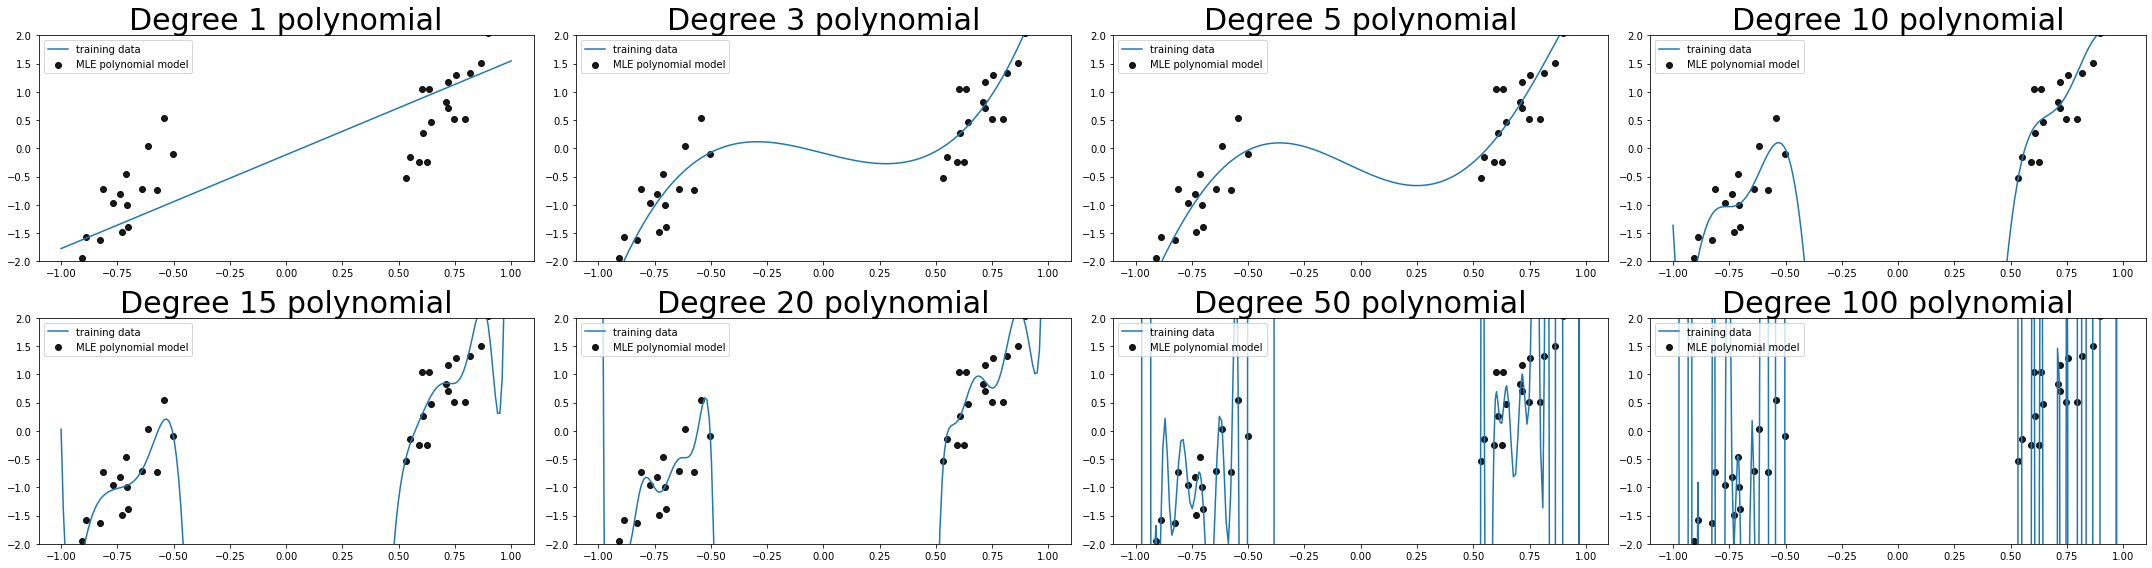

In [4]:
# Visualize the polynomial models
fig, ax = plt.subplots(2, 4, figsize=(30, 8))

for i in range(len(D)):
    ys = y_test_pred[i].flatten()
    row = i // 4
    col = i % 4
    ax[row, col].plot(x_test, ys, label='training data')
    ax[row, col].scatter(x_train, y_train, color='black', alpha=0.9, label='MLE polynomial model')
    ax[row, col].legend(loc='upper left')
    ax[row, col].set_title('Degree {} polynomial'.format(D[i]), fontsize= 30)
    ax[row, col].set_ylim((-2, 2))
    
plt.tight_layout()
plt.show()

It's clear that degree 1 is too simple to fit our training data; degree 3 and 5 appear to both fit the data welll and degrees 10, 15 and 20 appear to overfit, in the sense that these models are clearly trying to capture the random and meaningless noise in the data. The problem with our observations is that there's no way, by simply visualizing the data, that we can tell with certainty what is noise and what is signal in the data set! One way to quantify overfitting is by comparing the difference between training error (or likelihood) and test errror (or likelihood).

Typically, by test data we mean data ***sampled from the same distribution as the training data***. But in real-life applications, our test data is frequently not sampled from the same places as the training data. In fact, we certainly can't count on having labels for `x_test` in order to perform model selection!

So, let's generate another toy dataset like our training dataset from our data generating function and test our models on the new **validation** dataset.

In [5]:
# Generate a random training samples from the true distribution over x
x_train_new, y_train_new, _ = generate_data(number_of_points=20, noise_variance=0.3) 

# Fit MLE polynomial models with different degrees to the dataset
for d in D:
    # Make an instance of the PolynomialFeatures model to add polynomial powers to our covariates
    poly = PolynomialFeatures(d) 
    # Fit a polynomial model
    x_train_poly = poly.fit_transform(x_train.reshape((-1, 1))) 
    x_new_poly = poly.fit_transform(x_train_new.reshape((-1, 1))) 
    linear_regressor.fit(x_train_poly, y_train.reshape(-1, 1)) 
    # Make predictions
    y_train_pred = linear_regressor.predict(x_train_poly).flatten()
    y_new_pred = linear_regressor.predict(x_new_poly).flatten()
    # Compute MSEs
    train_mse = np.mean((y_train - y_train_pred)**2)
    test_mse = np.mean((y_train_new - y_new_pred)**2)
    print('Degree {}: train mse {}, test mse {}'.format(d, train_mse, test_mse))

Degree 1: train mse 0.5933600653284674, test mse 0.40750363860686445
Degree 3: train mse 0.20654668229519207, test mse 0.3710881596779056
Degree 5: train mse 0.2016393964304139, test mse 0.37824039692567374
Degree 10: train mse 0.1749119142811923, test mse 0.4579850284326897
Degree 15: train mse 0.16540995401750502, test mse 0.9990627995847463
Degree 20: train mse 0.15073755605571346, test mse 0.9266435604675649
Degree 50: train mse 0.039243831965778846, test mse 76624416190.26541
Degree 100: train mse 3.369649656765722, test mse 9.537639643219396e+19


Now, with a new toy dataset sampled from the same distribution as our training dataset, we can see evidence that degrees 15 and higher are indeed overfitting. But although we decided, based on our visual anlysis, that the degree 10 polynomial model is overfitting, the difference between train and test MSE for this model is not significantly different from the degree 3 or degree 5 model. 

Finally, it is clear from the model visualizations that degrees 20, 50 and 100 are very inappropriate for our dataset - since these polynomials are beginning to interpolate the data (i.e. going through every single training data point)!

2. **(Model Selection)** Later in the course, we will study a number of metrics commonly used for selecting between different MLE models. All of these metric essentially encode Occam's Razor: select the minimal complexity of model that satisfies some pre-determined modeling goal. <br><br>
For now, a very simple method for selecting the optimal degree is via cross-validation (by bootstrap):

  1. randomly sample two datasets from the observed data: one for training and one for validation. Fit an MLE  polynomial model of degree $d$ on the training data and evaluate its performance on the validation data. Over $S$ number of such randomly sampled pairs of datasets, average the model's validation performance.
  2. plot the validation score as a function of model complexity, the polynomial degree $d$. 
  3. based on the plot, select the the minimal degree that achieves a high average validation performance (i.e. look for the 'elbow' of the plot).

  Explain why performing model selection by cross-validation mitigates the risk of choosing an undesirable polynomial (identified in Problem 1)?<br><br>
  Implement model selection by cross-validation for the toy dataset generated in Problem 1 using MSE as your performance metric and select an optimal degree from $D=[1,3,5,10,15,20,50,100]$.

In [6]:
S = 100
validation_mse = []

# Repeat for S number of trials
for s in range(S):
    
    # Generate a random training samples from the true distribution over x
    x_train, y_train, _ = generate_data(number_of_points=20, noise_variance=0.3)
    # Generate a random validation samples from the true distribution over x
    x_valid, y_valid, _ = generate_data(number_of_points=20, noise_variance=0.3)
    
    mse = []
    # Fit MLE polynomial models with different degrees to the dataset
    for d in D:
        # Make an instance of the PolynomialFeatures model to add polynomial powers to our covariates
        poly = PolynomialFeatures(d) 
        # Fit a polynomial model
        x_train_poly = poly.fit_transform(x_train.reshape((-1, 1))) 
        x_valid_poly = poly.fit_transform(x_valid.reshape((-1, 1))) 
        linear_regressor.fit(x_train_poly, y_train.reshape(-1, 1)) 
        # Make predictions
        y_valid_pred = linear_regressor.predict(x_valid_poly).flatten()
        mse.append(np.mean((y_valid - y_valid_pred)**2))
    validation_mse.append(mse)

validation_mse = np.array(validation_mse)

# Average the validation MSE across trials
validation_mse = validation_mse.mean(axis=0)

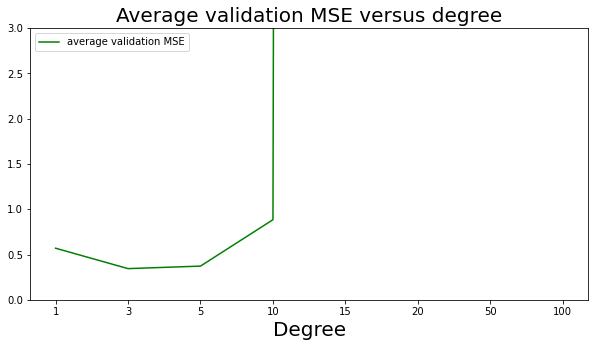

In [7]:
# Visualize the average validation mse for each degree
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(np.arange(len(D)), validation_mse, color='green', label='average validation MSE')
ax.set_xticks(np.arange(len(D)))
ax.set_xticklabels(D)
ax.set_title('Average validation MSE versus degree', fontsize= 20)
ax.legend(loc='upper left')
ax.set_ylim((0, 3))
ax.set_xlabel('Degree',  fontsize= 20)
plt.show()

It looks like the lowest average validation MSE is achieved at degree 3, although degree 5 also looks competitive in terms of having a low average validation MSE. The advantage of selecting models based on  validation score is that we can more easily identify models that are too complex for the data, these models will tend to overfit to the training data (they are sensitive to minute changes in the training data) and will generally have higher MSE on validation data sampled from the same distribution. The reason we want to compute the ***average validation MSE*** over multiple validation datasets is that evaluating the performance of our models on one set of validation data can be misleading! For example, in Exercise 1 we thought that the degree 10 model looked comparable with degrees 3 and 5 based on its performance on one validation dataset!

3. **(Uncertainty Estimation)** As you have seen in HW0, we often use the bootstrap predictive uncertainty of MLE models as an indicator of our confidence in the model's output. Increasingly, in practice, decisions making are deferred to human experts when the model's predictive uncertainty is too high. <br><br>
Given your understanding of the dataset, describe what the model uncertainty ***should*** ideally look like across the input space (i.e. if you plotted the model uncertainty as a function of $x$, what would it look like)? Justify your answer: consider the context of the problem: the test input has undergone covariate shift and is dissmilar to the training input, what kind of uncertainty would help you mitigate risk under this condition?<br><br>
A common practice for estimating predictive uncertainty is to fit a large number of (bootstrap) models on the training data (this collection of models is called an **ensemble**) and, at an input $x$, use the variance of the ensemble predictions to estimate the uncertainty at $x$. Plot the 95% predictive interval of 200 bootstrap MLE polynomial models for each degree $D=[1,3,5,10,15,20,50,100]$, arrange your plots as subplots in a single figure. For which polynomial degree do you obtain the predictive uncertainty that is most ideal (according to your description above)? Is this the degree you selected in Problem 2? Explain why you would or would not expect the optimal degree in Problem 2 to yield the most ideal uncertainty estimate.<br><br>
Make the same plots the 95% predictive intervals for degrees $D=[1,3,5,10,15,20,50,100]$, with models fitted on larger training datasets - set `number_of_points` to 50, 100, 500, 1000 (arrange all these plots in a single figure). What is happening to the predictions of the ensemble in the training data rich region? What is happening to the predictions of the ensemble in the training data poor region? Are these expected behaviours (relate what you see in both cases to the asymptotic properties of MLE)?
<br><br>
When the training data is abundant (`number_of_points=1000`), are any of the 95% predictive intervals ideal (according to your description above)? What does this imply about the feasibility of using the variance of the ensemble predictions to estimate predictive uncertainty at an input $x$?

**Solution:** Let's first look at a visualization of the training data!

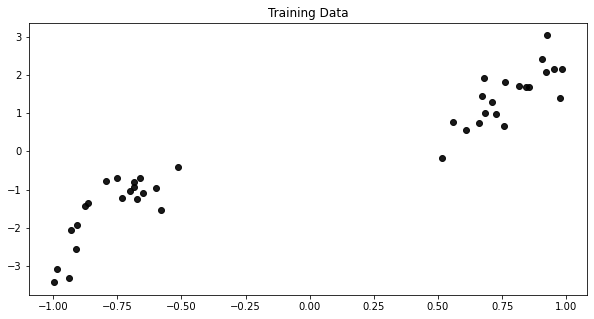

In [8]:
# Visualize the average validation mse for each degree
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(x_train, y_train, color='black', alpha=0.9)
ax.set_title('Training Data')
plt.show()

It looks like there is a large gap in the training data, $[-0.5, 0.5]$! If we want to defer decisions to humans experts when the model is uncertain - i.e. have a higher chance of being wrong - then we might want to do so for test x-values that are very disimilar to the training data. That is, the farther the test x-value is away from the data the more uncertain we'd want the model to be. As such, we'd expect the model uncertainty to be the highest at $x=0$ and progressively become lower as we approach the training data ($x=0.5$, $x=-0.5$). 

In [9]:
S = 100
predictions = []

# Repeat for S number of trials
for s in range(S):
    
    # Generate a random training samples from the true distribution over x
    x_train, y_train, _ = generate_data(number_of_points=20, noise_variance=0.3)
    
    y_test_pred = []
    # Fit MLE polynomial models with different degrees to the dataset
    for d in D:
        # Make an instance of the PolynomialFeatures model to add polynomial powers to our covariates
        poly = PolynomialFeatures(d) 
        # Fit a polynomial model
        x_train_poly = poly.fit_transform(x_train.reshape((-1, 1))) 
        x_test_poly = poly.fit_transform(x_test.reshape((-1, 1))) 
        linear_regressor.fit(x_train_poly, y_train.reshape(-1, 1)) 
        # Make predictions
        y_test_pred.append(linear_regressor.predict(x_test_poly).flatten())
        
    predictions.append(y_test_pred)

predictions = np.array(predictions)

In [10]:
# Compute the 97.5 th percentile of the posterior predictive predictions
pred_ub = np.percentile(predictions, 97.5, axis=0)

# Compute the 50 th percentile of the posterior predictive predictions
pred_mean = np.percentile(predictions, 50.0, axis=0)

# Compute the 2.5 th percentile of the posterior predictive predictions
pred_lb = np.percentile(predictions, 2.5, axis=0)

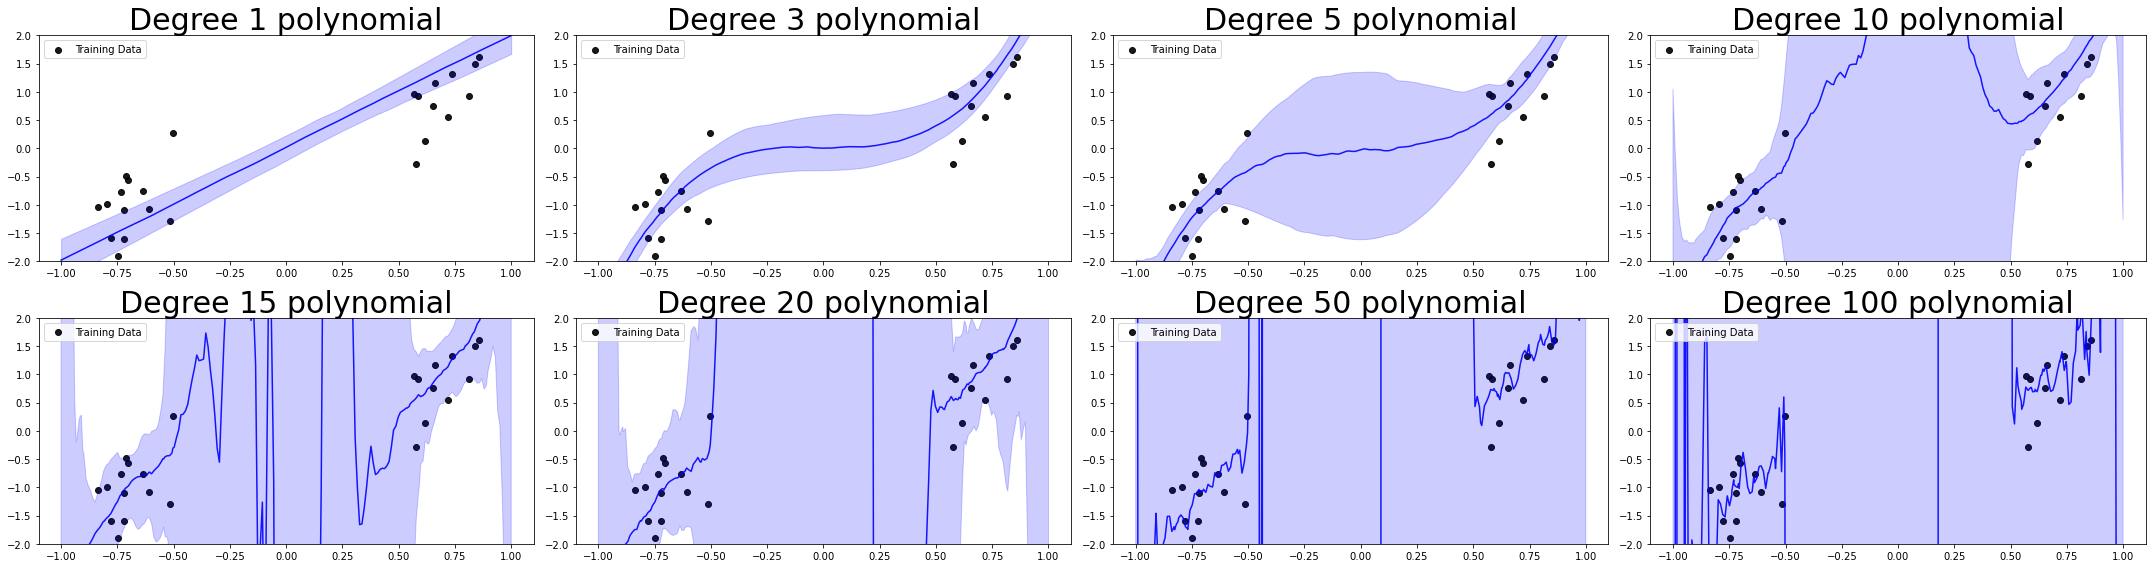

In [11]:
# Visualize the polynomial models
fig, ax = plt.subplots(2, 4, figsize=(30, 8))

for i in range(len(D)):
    ys = predictions[i].flatten()
    row = i // 4
    col = i % 4
    
    ax[row, col].scatter(x_train, y_train, color='black', alpha=0.9, label='Training Data') #scatter plot the training data
    
    # Plot 95% predictive interval
    ax[row, col].fill_between(x_test, pred_ub[i], pred_lb[i], color='blue', alpha=0.2)
    ax[row, col].plot(x_test, pred_mean[i], color='blue', alpha=0.9)
    
    ax[row, col].legend(loc='upper left')
    ax[row, col].set_title('Degree {} polynomial'.format(D[i]), fontsize= 30)
    ax[row, col].set_ylim((-2, 2))
    
plt.tight_layout()
plt.show()

We see from the above that, the predictive uncertainties of a degree 1 model is approximately constant across $[-1, 1]$ and hence this model is as confident on training data poor regions as it is on training data rich regions. 

The degree 3 model is more uncertain in the training data poor region $[-0.5, 0.5]$, but it's uncertainty doesn't scale with distance from the training data - meaning, it's just as uncertain at $x=0$ as it is at $x=0.3$. 

For all models with degree 5 and above, we have higher uncertainty in the gap region $[-0.5, 0.5]$ than in the training data rich regions. But for degrees 10 and above, again the uncertainty does not scale with distance from the training data - meaning, it's just as uncertain at $x=0$ as it is at $x=0.3$. Furthermore, the uncertainties of these models are extreme! Even their uncertainties on training data rich regions are extremely high (higher than the amount of noise in the data)!

Given our description of the ideal predictive uncertainty of a model, we might want to choose a degree 5 polynomial. But note that this is not the model we picked via cross-validation in Exercise 3! There, the law of parsimony (or Occam's Razor) dictated that we choose a degree 3 polynomial model since it was the minimally complex model that had the best validation performance. Now we see that a degree 3 model may be complex enough capture the signal in our data, but it's not expressive enough to generate higher predictive uncertainties in $[-0.5, 0.5]$ (generating higher uncertainties in the gap means fitting functions that can go through the data but curve higher or lower in $[-0.5, 0.5]$, can you see why?).

So what happens when we have a large number of observations?

In [12]:
S = 100
sample_size = [50, 100, 500, 1000]
predictions = []
x_train_samples = []
y_train_samples = []

for size in sample_size:
    
    pred_per_data = []

    # Repeat for S number of trials
    for s in range(S):

        # Generate a random training samples from the true distribution over x
        x_train_sample, y_train_sample, _ = generate_data(number_of_points=size, noise_variance=0.3)
        y_test_pred = []
        # Fit MLE polynomial models with different degrees to the dataset
        for d in D:
            # Make an instance of the PolynomialFeatures model to add polynomial powers to our covariates
            poly = PolynomialFeatures(d) 
            # Fit a polynomial model
            x_train_poly = poly.fit_transform(x_train_sample.reshape((-1, 1))) 
            x_test_poly = poly.fit_transform(x_test.reshape((-1, 1))) 
            linear_regressor.fit(x_train_poly, y_train_sample.reshape(-1, 1)) 
            # Make predictions
            y_test_pred.append(linear_regressor.predict(x_test_poly).flatten())
        pred_per_data.append(y_test_pred)  
        
    x_train_samples.append(x_train_sample)
    y_train_samples.append(y_train_sample)

    predictions.append(pred_per_data)

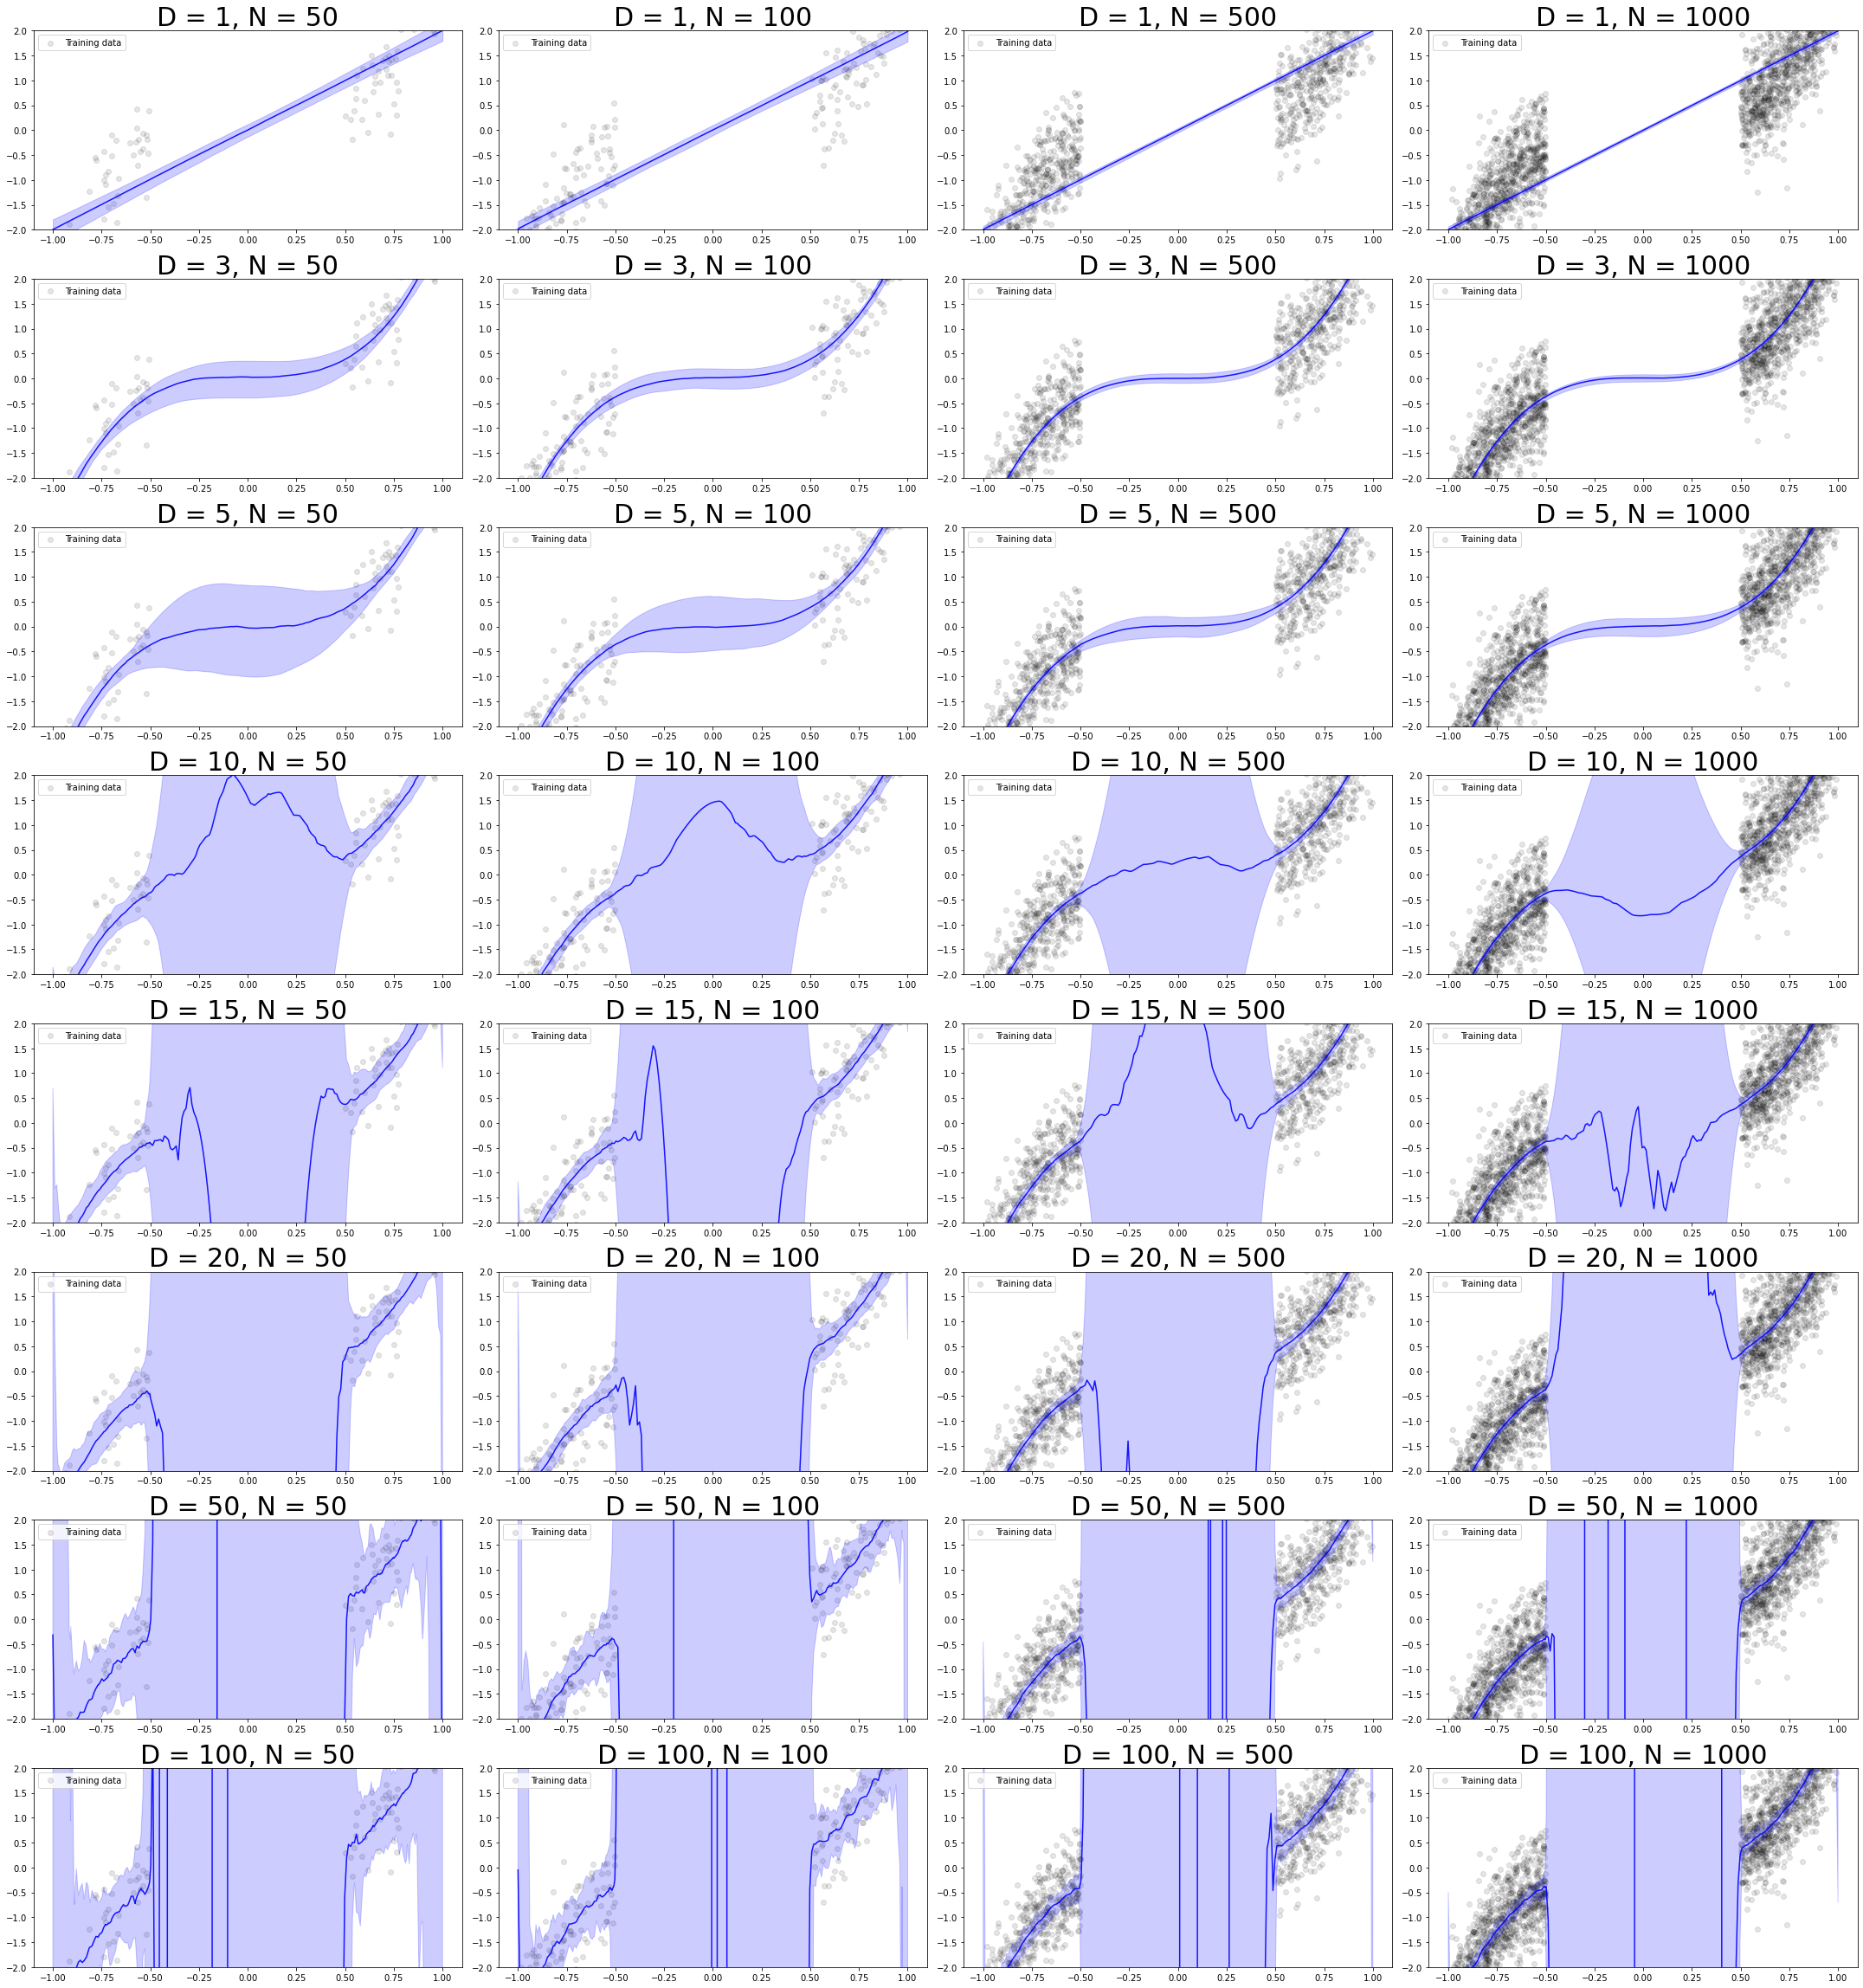

In [13]:
# Visualize the polynomial models
fig, ax = plt.subplots(8, 4, figsize=(30, 32))

for i in range(len(sample_size)):
    
    y_preds = predictions[i]
    
    # Compute the 97.5 th percentile of the posterior predictive predictions
    pred_ub = np.percentile(y_preds, 97.5, axis=0)

    # Compute the 50 th percentile of the posterior predictive predictions
    pred_mean = np.percentile(y_preds, 50.0, axis=0)

    # Compute the 2.5 th percentile of the posterior predictive predictions
    pred_lb = np.percentile(y_preds, 2.5, axis=0)
    
    for j in range(len(D)):
        ax[j, i].scatter(x_train_samples[i], y_train_samples[i], color='black', alpha=0.1, label='Training data') #scatter plot the training data
    
        # Plot 95% predictive interval
        ax[j, i].fill_between(x_test, pred_ub[j], pred_lb[j], color='blue', alpha=0.2)
        ax[j, i].plot(x_test, pred_mean[j], color='blue', alpha=0.9)

        ax[j, i].legend(loc='upper left')
        ax[j, i].set_title('D = {}, N = {}'.format(D[j], sample_size[i]), fontsize=30)
        ax[j, i].set_ylim((-2, 2))
        
plt.tight_layout()
plt.show()

It look like that as the number of observations $N$ increases, the predictive uncertainty in training data rich regions $[-1, -0.5]\cap [0.5, 1]$ decreases a lot! In fact for $N=1000$, the 95% predictive interval of the ensemble covers far less than 95% of the data. That is, in these data rich regions, our ensemble is far more confident than it should be (there is still a lot of observation noise)! The addition of more observations, however, does not seem to significantly decrease the predictive uncertainty in the gap $[-0.5, 0.5]$ - these uncertainties remain extreme for high degree polynomials $D\geq 10$.

So why isn't doesn't there more variance in the predictions of our bootstrap MLE models? Well, recall that the asymptotic properties of maximum likelihood estimators gaurantee that our MLE becomes closer and closer to the true data generating model as $N\to \infty$ - this is happening to all of our bootstrap MLE models! So if each boostrap MLE model is approaching the same ground-truth model, then how much variation can there be amongst their predictions? This explanation sounds intuitive but is it formally sound -- i.e. is the consistency of MLE gauranteed for our experiment? 

Why isn't the uncertainty shrinking in the gap region? Aren't my bootstrap MLE models supposed to all approach the same ground-truth mode, when then is there so much variance in in the gap region? Well, this is because the asymptotic properties of MLE comes with caveats, in particular, in order for consistency to hold, we needed to assume that no two models could have generated our data. But this assumption fails for our "gap" dataset. While there is clearly one way to fit the data outside the gap, there are infinite number of ways to interpolate through the gap region. Hence any two functions that agreed outside the gap would fit our training data equally well. Thus, there is not a unique function that could have generated our training data. So actually consistency of MLE is not gauranteed here! So why is the beviour of the MLE expected in the data-rich regions and unexpected in the gap region? This is a good question to inspire a closer examination of the technical conditions of the consistency theorem for MLE and a great question for discussion during OH!

**Note:** This explanation is very high level and imprecise -- you are welcome to take up the challenge of trying to formalize this explanation by examining the conditions for the consistency of MLEs.

4. **(Effect of Regularization)** In practice, MLE models are nearly always trained with regularization (since they tend to overfit to the training data). Here, we will explore the effect of adding $\ell_2$ regularization to our MLE polynomial models (that is, use the `Ridge` regression model from `sklearn` after augmenting your input with polynomial features). <br><br>
For a toy dataset with 40 observations (`number_of_points=20`), plot the 95% predictive intervals for degrees $D = [1,3,5,10,15,20,50,100]$ and regularization strengths `alpha = [5e-3, 1e-2, 1e-1, 1e0, 1e1]` (you should organize these plots in a grid).<br><br>
Describe the effect of regularization on the bootstrap uncertainties. Looking at these results, are the goals of $\ell_2$ regularization and obtaining useful predictive uncertatinty estimation neccessarily well-aligned?


**Solution:** We'll make a grid of 95% predictive interval visualizations, with `alpha` varying along the columns and $D$ varying along the rows.

In [14]:
S = 100
alphas = [5e-3, 1e-2, 1e-1, 1e0, 1e1]
predictions = []


for alpha in alphas:
    
    pred_per_alpha = []

    # Repeat for S number of trials
    for s in range(S):

        # Generate a random training samples from the true distribution over x
        x_train_sample, y_train_sample, _ = generate_data(number_of_points=20, noise_variance=0.3)
        y_test_pred = []
        # Fit MLE polynomial models with different degrees to the dataset
        for d in D:
            # Make an instance of the PolynomialFeatures model to add polynomial powers to our covariates
            poly = PolynomialFeatures(d) 
            # Fit a regularized polynomial model
            x_train_poly = poly.fit_transform(x_train_sample.reshape((-1, 1))) 
            x_test_poly = poly.fit_transform(x_test.reshape((-1, 1))) 
            ridge_regressor = Ridge(alpha=alpha, max_iter=3000, fit_intercept=False)
            ridge_regressor.fit(x_train_poly, y_train_sample.reshape(-1, 1)) 
            # Make predictions
            y_test_pred.append(ridge_regressor.predict(x_test_poly).flatten())
        pred_per_alpha.append(y_test_pred)  

    predictions.append(pred_per_alpha)

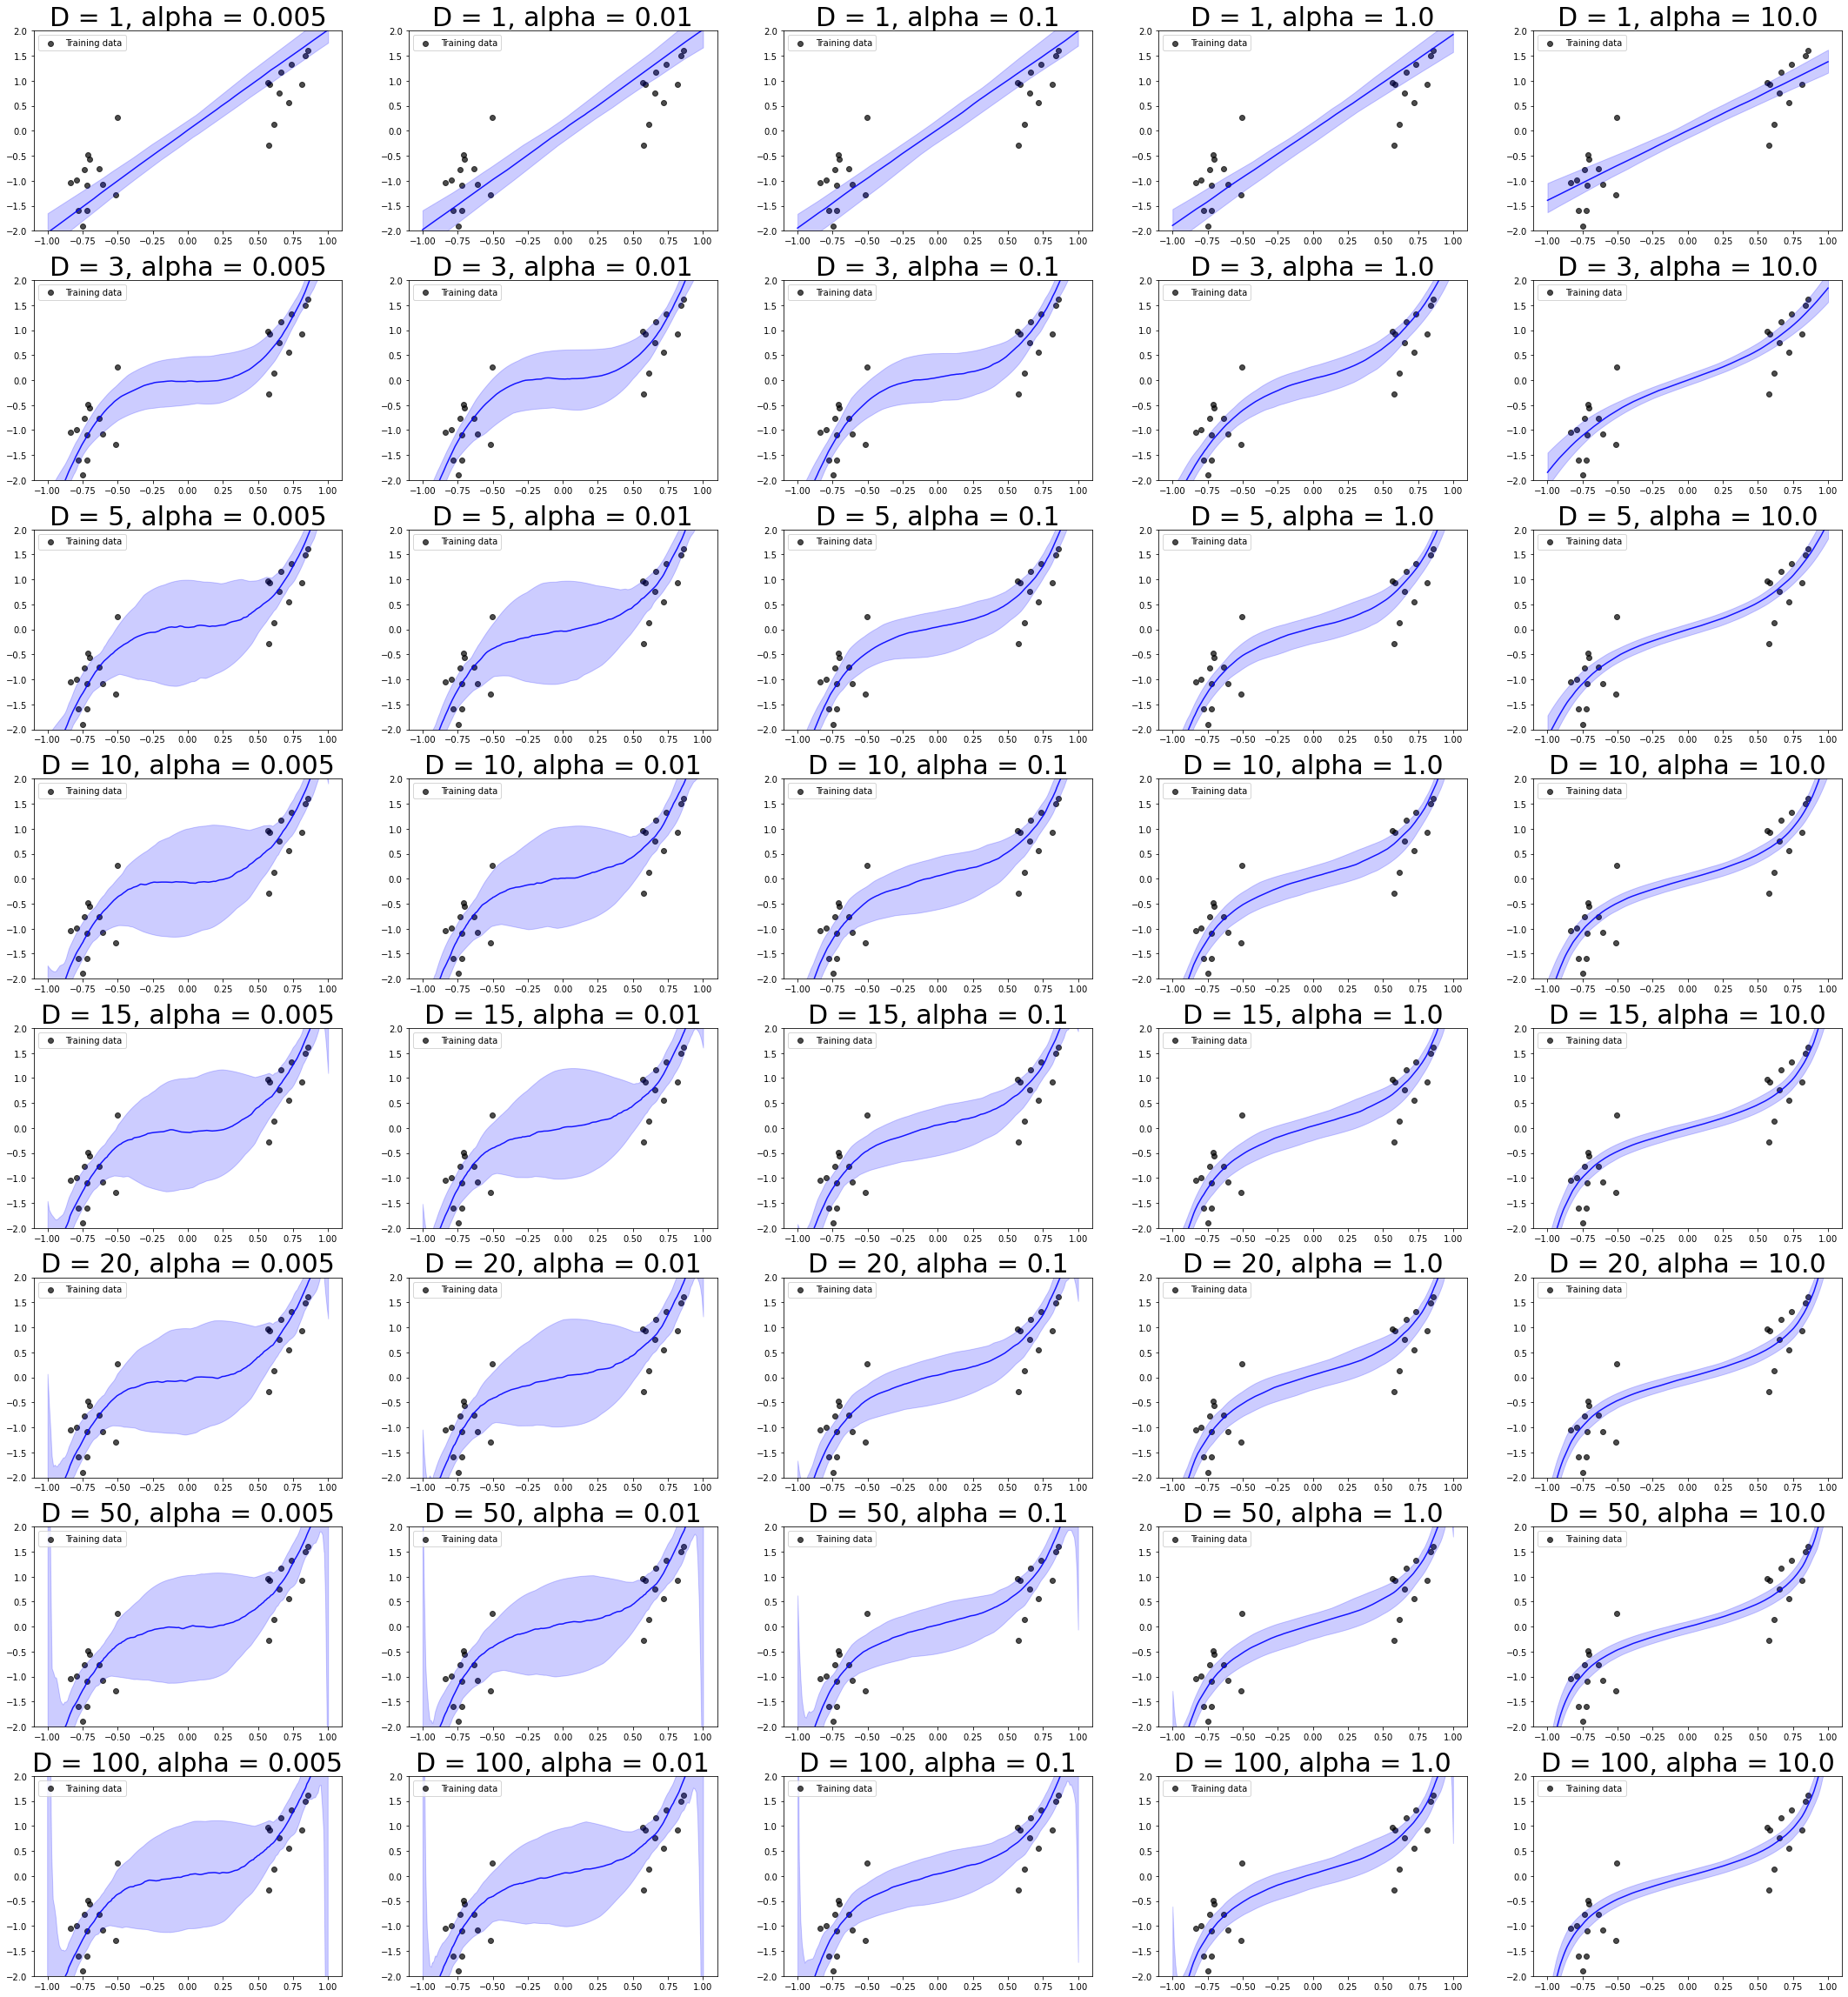

In [15]:
# Visualize the polynomial models
fig, ax = plt.subplots(8, 5, figsize=(30, 32))

for i in range(len(alphas)):
    
    y_preds = predictions[i]
    
    # Compute the 97.5 th percentile of the posterior predictive predictions
    pred_ub = np.percentile(y_preds, 97.5, axis=0)

    # Compute the 50 th percentile of the posterior predictive predictions
    pred_mean = np.percentile(y_preds, 50.0, axis=0)

    # Compute the 2.5 th percentile of the posterior predictive predictions
    pred_lb = np.percentile(y_preds, 2.5, axis=0)
    
    for j in range(len(D)):
        ax[j, i].scatter(x_train, y_train, color='black', alpha=0.7, label='Training data') #scatter plot the training data
    
        # Plot 95% predictive interval
        ax[j, i].fill_between(x_test, pred_ub[j], pred_lb[j], color='blue', alpha=0.2)
        ax[j, i].plot(x_test, pred_mean[j], color='blue', alpha=0.9)

        ax[j, i].legend(loc='upper left')
        ax[j, i].set_title('D = {}, alpha = {}'.format(D[j], alphas[i]), fontsize= 30)
        ax[j, i].set_ylim((-2, 2))
        
plt.tight_layout()
plt.show()

Looking at the above grid, we conclude that **many** of the uncertainties fail to satisfy our desiderata -- that we become more uncertain of our predictions the farther we are from the nearest training data. In particular, we observe that even a small amount of $\ell_2$ regularization (`alpha=0.1`) drastically reduces predictive uncertainty everywhere, regardless of the degree of the polynomial we choose! When the amount of $\ell_2$ regularization is high, predictive uncertainty can vanish (and the model can underfit)! 

So does this make sense? Is this what we expect to see? The answer is yes. Adding $\ell_2$ regularization allows the model we're fitting to vary conservatively (to take on non-constant values) as long as doing so helps us fit the data. But in order to produce high uncertainty in the gap region, we need our bootstrap models to vary greatly in this region that contains no training data, and this is explicitly discouraged by $\ell_2$ regularization!

This experiment indicates that applying regularization can help prevent overfitting, but we must worry that by doing so we are also preventing our bootstrap ensemble from producing meaningful predictive uncertainties.

## Part II: Bayesian Polynomial Regression
In this problem, your task is to perform Bayesian polynomial regression on the toy datasets in Part I. That is, assume that the outcome $y$ can be modeled by the following process:

\begin{align}
y &= f(x) + \epsilon = w_0 + w_1x + w_2x^2 + \ldots + w_Dx^D + \epsilon, \quad \epsilon \sim \mathcal{N}(0, 0.3)\\
w_d &\sim \mathcal{N}(0, \alpha)
\end{align}

where $\alpha$ is a hyperparameter and must be fixed before modeling and inference begins.

1. **(Bayesian Kernel Regression)** Just as we can treat a polynomial regression model like a multi-linear regression model after ***transforming*** the input data by adding polynomial features. We can treat Bayesian polynomial regression like Bayesian linear regression on top of the transformed inputs. Formally, the map that takes an input $\mathbf{x}_n \in \mathbb{R}^{D'}$ and transforms it into a new input $\phi(\mathbf{x}_n) \in \mathbb{R}^{D}$ is called a **feature map**, $\phi: \mathbb{R}^{D'} \to \mathbb{R}^{D}$, for 1-dimensional input $x \in \mathbb{R}$, the polynomial feature map of degree $D$ is defined by
\begin{align}
\\\phi: \mathbb{R} &\to \mathbb{R}^D\\
x &\mapsto [1, x, x^2, \ldots, x^D]\\
\end{align}
<br> Thus, we can write rewrite Bayesian polynomial regression as
\begin{align}
\\y &= \mathbf{w}^\top \phi(\mathbf{x}) + \epsilon, \quad \epsilon \sim \mathcal{N}(0, 0.3)\\
\mathbf{w} &\sim \mathcal{N}(0, \alpha I_{D\times D})\\
\end{align}
<br>Denote the $N\times D$ matrix of transformed inputs by $\Phi$, where the $n$-th row of the matrix is the $n$-th input $\mathbf{x}_n$ transformed by the feature map, $\phi(\mathbf{x}_n)$. Using this notation, write out the closed form for the posterior for Bayesian polynomial regression in terms of $\Phi$ (you don't need to rederive anything, just make the appropriate substitutions in the formula you derived in HW0).
<br><br>
For $\alpha = 1$ and $D=5$, visualize the 95% posterior predcitve interval of a Bayesian polynomial regression for the toy dataset with 40 observations (set `number_of_points=20`) in Part I.
<br><br>
When the feature map $\phi$ is a general (usually non-linear transformation), applying Bayesian linear regression on the transformed input is called **Bayesian Kernel Regression**. Choose your own non-linear feature map $\phi: \mathbb{R} \to \mathbb{R}^5$ and visualize the 95% posterior predictive interval of the Bayesian kernel regression for your choice of $\phi$. Compare the visualization to the that for Bayesian polynomial regression. Does the posterior predictive of your Bayesian kernel regression capture important properties of that of the Bayesian polynomial regression model?
<br><br>
**Note:** we highly recommend that you implement the following feature map:
<br><br>
\begin{align}
\phi: \mathbb{R}^{D'} &\to \mathbb{R}^D\\
\mathbf{x} &\mapsto \left[\sqrt{\frac{2}{D}} \cos(w_1^\top x + b_1), \ldots, \sqrt{\frac{2}{D}} \cos(w_D^\top x + b_D)\right]
\end{align}
<br>where $b_d \sim [0, 2\pi]$ and $w_d \sim \mathcal{N}(0, \beta I_{D'\times D'})$ need to be randomly sampled and fixed before modeling and inference. The features generated by $\phi$ are called **Random Fourier Features**. As the number of features $D$ tends to infinity, the resulting Bayesian kernel regression model tends to an important type of Bayesian (nonparametric) model called Gaussian Process model. We will revisit the connection between Bayesian kernel regression and Gaussian processes in the latter part of the course.

**Solution:** We first visualize the posterior predictive of a Bayesian Kernel Regression with a degree 5 polynomial feature map.

In [95]:
def generate_data(number_of_points=10, noise_variance=0.3):
    '''Function for generating toy regression data'''
    #training x
    x_train = np.sort(np.hstack((np.random.uniform(-1, -0.5, number_of_points), np.random.uniform(0.5, 1, number_of_points))))
    
    #function relating x and y
    f = lambda x: 3 * x**3
    #y is equal to f(x) plus gaussian noise
    y_train = f(x_train) + np.random.normal(0, noise_variance**0.5, 2 * number_of_points)
    x_test = np.array(list(set(list(np.hstack((np.linspace(-1, 1, 200), x_train))))))
    x_test = np.sort(x_test)
    y_test = f(x_test) + np.random.normal(0, noise_variance**0.5, size=x_test.shape)
    return x_train, y_train, x_test

In [96]:
# Generate a random training samples from the true distribution over x
x_train, y_train, x_test = generate_data(number_of_points=100, noise_variance=0.1) 

In [127]:
# Make an instance of the PolynomialFeatures model to add polynomial powers to our covariates
poly = PolynomialFeatures(4)

# Fit our PolynomialFeatures to our data and add add polynomial powers to our covariates
x_train_poly = poly.fit_transform(x_train.reshape((-1, 1)))
x_test_poly = poly.fit_transform(x_test.reshape((-1, 1)))

In [128]:
# Define noise level in the data
noise_variance = 0.05

# Define the variance of the prior distribution
prior_variance = 35.

# Define the number of samples to take from the posterior
samples = 100

# Get samples from the posterior predictive
posterior_predictions, posterior_predictive_samples = get_posterior_samples(prior_variance, noise_variance, x_train_poly, y_train.reshape((-1, 1)), x_test_poly, samples)

In [129]:
# Compute the 97.5 th percentile of the posterior predictive predictions
pp_upper = np.percentile(posterior_predictive_samples, 97.5, axis=0)

# Compute the 2.5 th percentile of the posterior predictive predictions
pp_lower = np.percentile(posterior_predictive_samples, 2.5, axis=0)

# Compute the 50 th percentile of the posterior predictive predictions
pp_mean = np.mean(posterior_predictive_samples, axis=0)

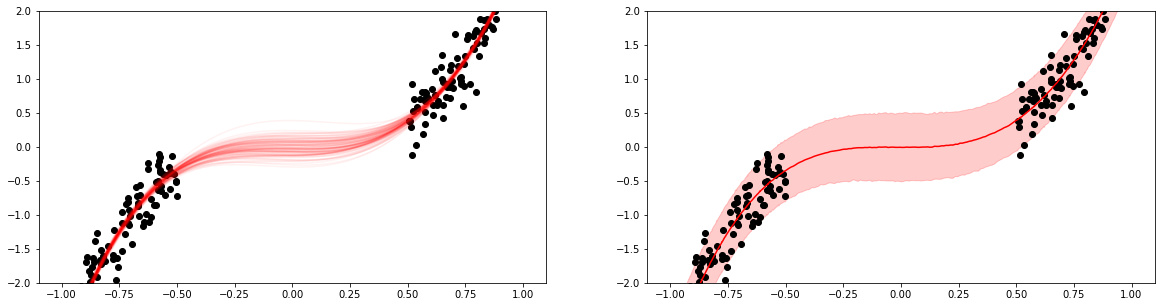

In [130]:
# Visualize the posterior predictive distribution
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

ax[0].scatter(x_train, y_train, color='black', label='training data') # visualize the training data 

for sample in posterior_predictions:
    ax[0].plot(x_test, sample, color='red', alpha=0.05) # visualize each model from the posterior

ax[0].set_ylim([-2, 2])
# ax[0].set_title('Polynomial Features: visualization of {} models from the posterior'.format(samples))

ax[1].plot(x_test, pp_mean, color='red') # visualize the mean of the posterior predictive
ax[1].fill_between(x_test, pp_upper, pp_lower, color='red', alpha=0.2, label='posterior mean') # visualize the 95% posterior predictive interval
ax[1].scatter(x_train, y_train, color='black', label='training data') # visualize the training data

# ax[1].legend(loc='best')
# ax[1].set_title('Polynomial Features: posterior predictive of linear model using polynomial features')
ax[1].set_ylim([-2, 2])
plt.show()

In [123]:
from sklearn.gaussian_process import GaussianProcessRegressor, GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern, RationalQuadratic, ExpSineSquared, Exponentiation
from sklearn.preprocessing import StandardScaler


# Define an RBF kernel for the GP prior
amplitude = 1.
length_scale = 1.
noise_var = 0.01
prior_kernel = amplitude * RBF(length_scale, length_scale_bounds='fixed') + WhiteKernel(noise_level=noise_var)#, noise_level_bounds='fixed')
# prior_kernel = RationalQuadratic(length_scale=1.0, alpha=1.5) + WhiteKernel(noise_level=noise_var)
# prior_kernel = ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=noise_var)
# prior_kernel = Exponentiation(RationalQuadratic(), exponent=2) + WhiteKernel(noise_level=noise_var)


# Instantiate a sklearn GP Regressor model
gp_regressor = GaussianProcessRegressor(kernel=prior_kernel, random_state=0)
gp_regressor.fit(x_train.reshape((-1, 1)), y_train) 

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=0.01),
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=0)

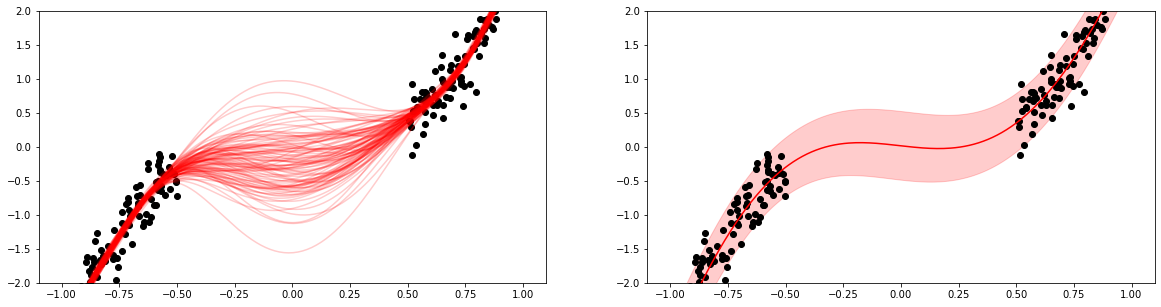

In [126]:
y_pred_mean, y_pred_std = gp_regressor.predict(x_test.reshape((-1, 1)), return_std=True)

# Visualize the posterior predictive distribution
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

ax[0].scatter(x_train, y_train, color='black', label='training data') # visualize the training data 

for sample in posterior_predictions:
    ax[0].plot(x_test, sample, color='red', alpha=0.2) # visualize each model from the posterior

ax[0].set_ylim([-2, 2])
# ax[0].set_title('Polynomial Features: visualization of {} models from the posterior'.format(samples))

ax[1].plot(x_test, y_pred_mean, color='red') # visualize the mean of the posterior predictive
ax[1].fill_between(x_test, y_pred_mean + 1.5 * y_pred_std, y_pred_mean - 1.5 * y_pred_std, color='red', alpha=0.2, label='posterior mean') # visualize the 95% posterior predictive interval
ax[1].scatter(x_train, y_train, color='black', label='training data') # visualize the training data

# ax[1].legend(loc='best')
# ax[1].set_title('Polynomial Features: posterior predictive of linear model using polynomial features')
ax[1].set_ylim([-2, 2])
plt.show()

We see that with $\alpha =1$ and degree 5 polynomial features, we don't get the desired uncertainties in the posterior predictive of Bayesian Kernel Regression. 

Now let's implement Bayesian Kernel Regression with Random Fourier Features.

In [20]:
def rff_expansion(x_train, x_test, beta, D, x_valid=None):
    w = np.random.normal(0, beta**0.5, size=(D, 1))
    b = np.random.uniform(0, 2 * np.pi, size=(D, 1))
    x_train_rff =  np.cos(w.dot(x_train.reshape((1, -1))) + b) * np.sqrt(2. / D)
    x_test_rff = np.cos(w.dot(x_test.reshape((1, -1))) + b)  * np.sqrt(2. / D)
    x_valid_rff = None
    if x_valid is not None:
        x_valid_rff = (np.cos(w.dot(x_valid.reshape((1, -1))) + b)  * np.sqrt(2. / D)).T
    return x_train_rff.T, x_test_rff.T, x_valid_rff

In [21]:
beta = 5
D = 5
# Add random fourier features to our covariates
x_train_rff, x_test_rff, _ = rff_expansion(x_train.reshape((-1, 1)), x_test.reshape((-1, 1)), beta, D)

In [22]:
# Define noise level in the data
noise_variance = 0.3

# Define the variance of the prior distribution
prior_variance = 1.

# Define the number of samples to take from the posterior
samples = 100

# Get samples from the posterior predictive
posterior_predictions, posterior_predictive_samples = get_posterior_samples(prior_variance, noise_variance, x_train_rff, y_train.reshape((-1, 1)), x_test_rff, samples)

In [23]:
# Compute the 97.5 th percentile of the posterior predictive predictions
pp_upper = np.percentile(posterior_predictive_samples, 97.5, axis=0)

# Compute the 2.5 th percentile of the posterior predictive predictions
pp_lower = np.percentile(posterior_predictive_samples, 2.5, axis=0)

# Compute the 50 th percentile of the posterior predictive predictions
pp_mean = np.mean(posterior_predictive_samples, axis=0)

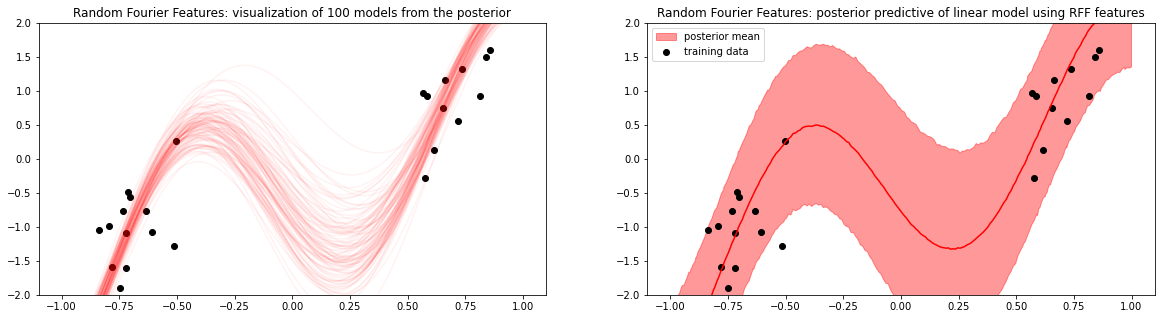

In [24]:
# Visualize the posterior predictive distribution
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

ax[0].scatter(x_train, y_train, color='black', label='training data') # visualize the training data 

for sample in posterior_predictions:
    ax[0].plot(x_test, sample, color='red', alpha=0.05) # visualize each model from the posterior

ax[0].set_ylim([-2, 2])
ax[0].set_title('Random Fourier Features: visualization of {} models from the posterior'.format(samples))

ax[1].plot(x_test, pp_mean, color='red') # visualize the mean of the posterior predictive
ax[1].fill_between(x_test, pp_upper, pp_lower, color='red', alpha=0.4, label='posterior mean') # visualize the 95% posterior predictive interval
ax[1].scatter(x_train, y_train, color='black', label='training data') # visualize the training data

ax[1].legend(loc='best')
ax[1].set_title('Random Fourier Features: posterior predictive of linear model using RFF features')
ax[1].set_ylim([-2, 2])
plt.show()

We see that with $\alpha =1$ and 5 random fourier features, we don't get the desired uncertainties in the posterior predictive of Bayesian Kernel Regression - the predictive uncertainty is still more or less constant across the gap region.

2. **(Effect of Model Complexity)** For Bayesian kernel regression, you need to pre-determine the number of features (i.e. $D$) and the hyperparameter $\alpha$ in the prior. For the toy dataset with 40 observations (set number_of_points=20) in Part I, visualize the 95% posterior predictive interval for $D = [1,3,5,10,15,20,50,100]$ and $\alpha = [0.1, 1, 5, 10, 100]$ (arrange these visualizations in a grid), using either Bayesian polynomial regression (or Bayesian kernel regression using Random Fourier Features). 
<br><br>
Based on your visualizaion, describe in intuitive terms what is the role of $\alpha$ and $D$ in determining the shape of the posterior predictive uncertainty. 
<br><br>
***Hint:*** Read Problem 3 before implementing Problem 2, you can implement both at the same time.

**Solution:**  We'll make a grid of 95% posterior predictive interval visualizations with random fourier features, with $\alpha$ varying along the columns and $D$ varying along the rows.

In [25]:
alphas = [0.1, 1, 5, 10, 100]
predictions = []
degrees = [1, 3, 5, 10, 15, 20, 50, 100]
    
for alpha in alphas:
    
    y_test_pred = []
    # Fit MLE polynomial models with different degrees to the dataset
    for d in degrees:
        # Make an instance of the PolynomialFeatures model to add polynomial powers to our covariates
        poly = PolynomialFeatures(d)
        # Fit our PolynomialFeatures to our data and add add polynomial powers to our covariates
        x_train_poly = poly.fit_transform(x_train.reshape((-1, 1)))
        x_test_poly = poly.fit_transform(x_test.reshape((-1, 1)))
        # Get samples from the posterior predictive
        _, posterior_predictive_samples = get_posterior_samples(alpha, noise_variance, x_train_poly, y_train.reshape((-1, 1)), x_test_poly, samples)
        # Make predictions
        y_test_pred.append(posterior_predictive_samples)
    predictions.append(y_test_pred)

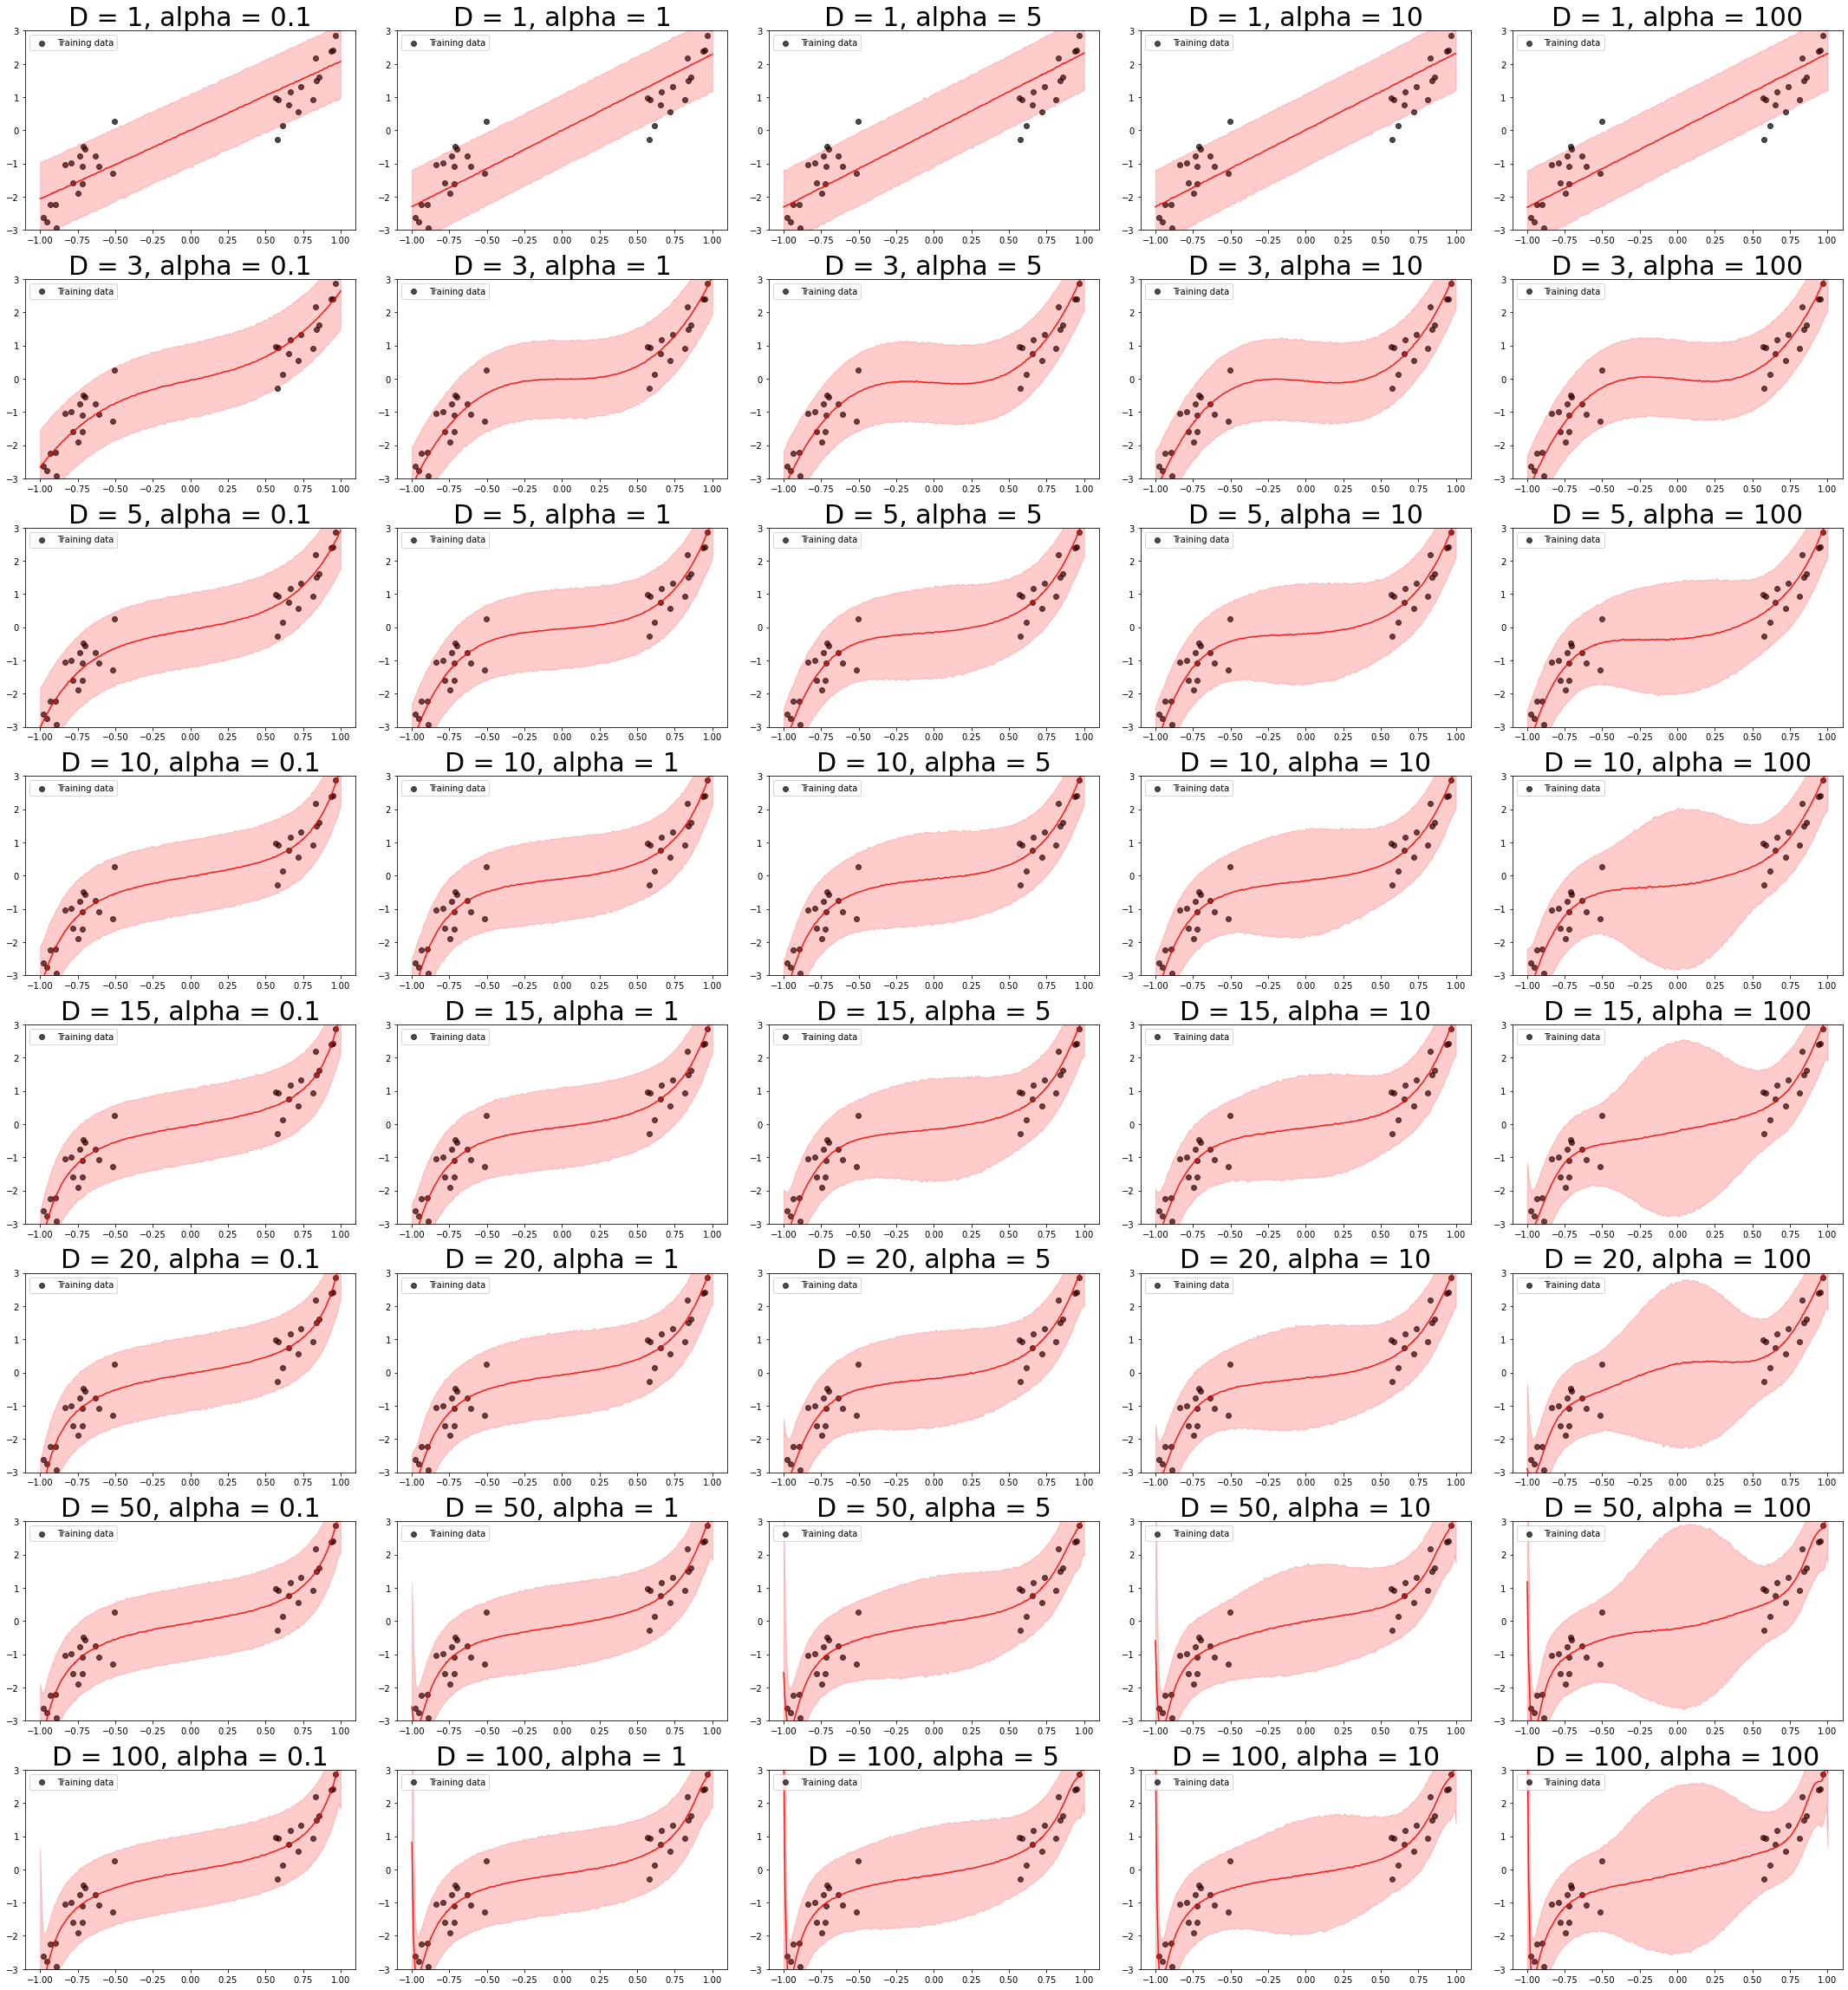

In [26]:
# Visualize the polynomial models
fig, ax = plt.subplots(8, 5, figsize=(30, 32))

for i in range(len(alphas)):
    
    y_preds = predictions[i]
    
    # Compute the 97.5 th percentile of the posterior predictive predictions
    pred_ub = np.percentile(y_preds, 97.5, axis=1)

    # Compute the 50 th percentile of the posterior predictive predictions
    pred_mean = np.percentile(y_preds, 50.0, axis=1)

    # Compute the 2.5 th percentile of the posterior predictive predictions
    pred_lb = np.percentile(y_preds, 2.5, axis=1)
    
    for j in range(len(degrees)):
        ax[j, i].scatter(x_train, y_train, color='black', alpha=0.7, label='Training data') #scatter plot the training data
    
        # Plot 95% predictive interval
        ax[j, i].fill_between(x_test, pred_ub[j], pred_lb[j], color='red', alpha=0.2)
        ax[j, i].plot(x_test, pred_mean[j], color='red', alpha=0.9)

        ax[j, i].legend(loc='upper left')
        ax[j, i].set_title('D = {}, alpha = {}'.format(degrees[j], alphas[i]), fontsize= 30)
        ax[j, i].set_ylim((-3, 3))
        
plt.tight_layout()
plt.show()

From the above, we can conclude that both $\alpha$ and $D$ impacts the shape of the posterior predictive. When $\alpha$ is ver high (and $D$ is large enough) or when $D$ is ver large (and $\alpha$ is large enough), the predictive uncertainty in the gap region becomes very high. When either $\alpha$ or $D$ is too low, the predictive uncertainty in the gap become constant and similar to the uncertainty in training data rich regions. 

The greatest impact of $\alpha$ and $D$ is on the predictive uncertainty in the gap region. Outside the gap the predictive uncertainty appears to be determined by the amount of noise in the data, across all choices of $\alpha$ and $D$.

3. **(Model Evaluation and Uncertainty Estimation)** Since a direct visual comparision of the 95% predictive interval against the training data is impractical! Rather, to evaluate the fit of the Bayesian model on the observed data, we evaluate the marginal log-likelihood of the data under hte posterior. Given a test set $\{(\mathbf{x}^*_m, \mathbf{y}^*_m)\}$, the log posterior predictive likelihood or, simply, the **log-likelihood** is computed as:
\begin{align}
\\ \log \prod_{m=1}^M p(\mathbf{y}^*_m | \mathbf{x}^*_m, \text{Data}) &= \sum_{m=1}^M \log p(\mathbf{y}^*_m | \mathbf{x}^*_m, \text{Data})\\
&= \sum_{m=1}^M \log \int_\mathbf{w} p(\mathbf{y}^*_m | \mathbf{x}^*_m, \mathbf{w}) p(\mathbf{w}| \text{Data}) d\mathbf{w}
\end{align}
<br>i.e. the log-likelihood at a single observation $(\mathbf{x}^*_m, \mathbf{y}^*_m)$ is the log of the likelihood of the observation ***averaged over all models in the posterior***. 
<br><br>
For Bayesian linear regression, with posterior $\mathcal{N}(\mu_N, \Sigma_N)$ we have that
$$
p(y^*_m | x^*_m, \text{Data}) = \mathcal{N}(\mu^\top\mathbf{x}^*_m, \sigma^2 + (\mathbf{x}^*_m)^\top\Sigma_N\mathbf{x}^*_m)
$$
where $\sigma^2$ is the variance of the observation noise.
<br><br>
For each choice of $D$ and $\alpha$ in Problem 2, compute the log-likelihood of the training data. Examine a models with the higher log-likelihoods and a few with lower log-likelihoods, do these models have the most desirable predictive uncertainties - that is does a high log-likelihood indicate "better" predictive uncertainty?

**Solution:** We'll make a grid of 95% posterior predictive interval visualizations with random fourier features, with $\alpha$ varying along the columns and $D$ varying along the rows.

In [27]:
def log_likelihood(prior_var, noise_var, x_train_features, y_train, x_val_features, y_val):

    prior_variance = np.diag(prior_var * np.ones(x_train_features.shape[1]))
    prior_precision = np.linalg.inv(prior_variance)

    precision = prior_precision + x_train_features.T.dot(x_train_features) / noise_var
    Sigma = np.linalg.inv(precision)

    mu = Sigma.dot(x_train_features.T.dot(y_train.reshape((-1, 1)))) / noise_var
    
    
    llkhd = 0
    for i in range(len(y_val)):
        mean = mu.T.dot(x_val_features[i].reshape((-1, 1))).flatten()[0]
        var = noise_var + x_val_features[i].T.dot(Sigma.dot(x_val_features[i]))
        logpdf = norm(mean, var**0.5).logpdf
        llkhd += logpdf(y_val[i])
        
    return llkhd

In [28]:
alphas = [0.1, 1, 5, 10, 100]
predictions = []
degrees = [1, 3, 5, 10, 15, 20, 50, 100]
llkhds = []
    
for alpha in alphas:
    
    y_test_pred = []
    llkhds_per_alpha = []
    # Fit MLE polynomial models with different degrees to the dataset
    for d in degrees:
        # Make an instance of the PolynomialFeatures model to add polynomial powers to our covariates
        poly = PolynomialFeatures(d)
        # Fit our PolynomialFeatures to our data and add add polynomial powers to our covariates
        x_train_poly = poly.fit_transform(x_train.reshape((-1, 1)))
        x_test_poly = poly.fit_transform(x_test.reshape((-1, 1)))

        # Get samples from the posterior predictive
        _, posterior_predictive_samples = get_posterior_samples(alpha, noise_variance, x_train_poly, y_train.reshape((-1, 1)), x_test_poly, samples)
        # Make predictions
        y_test_pred.append(posterior_predictive_samples)
        llkhds_per_alpha.append(log_likelihood(alpha, noise_variance, x_train_poly, y_train, x_train_poly, y_train))
        
    llkhds.append(llkhds_per_alpha)
        
    predictions.append(y_test_pred)

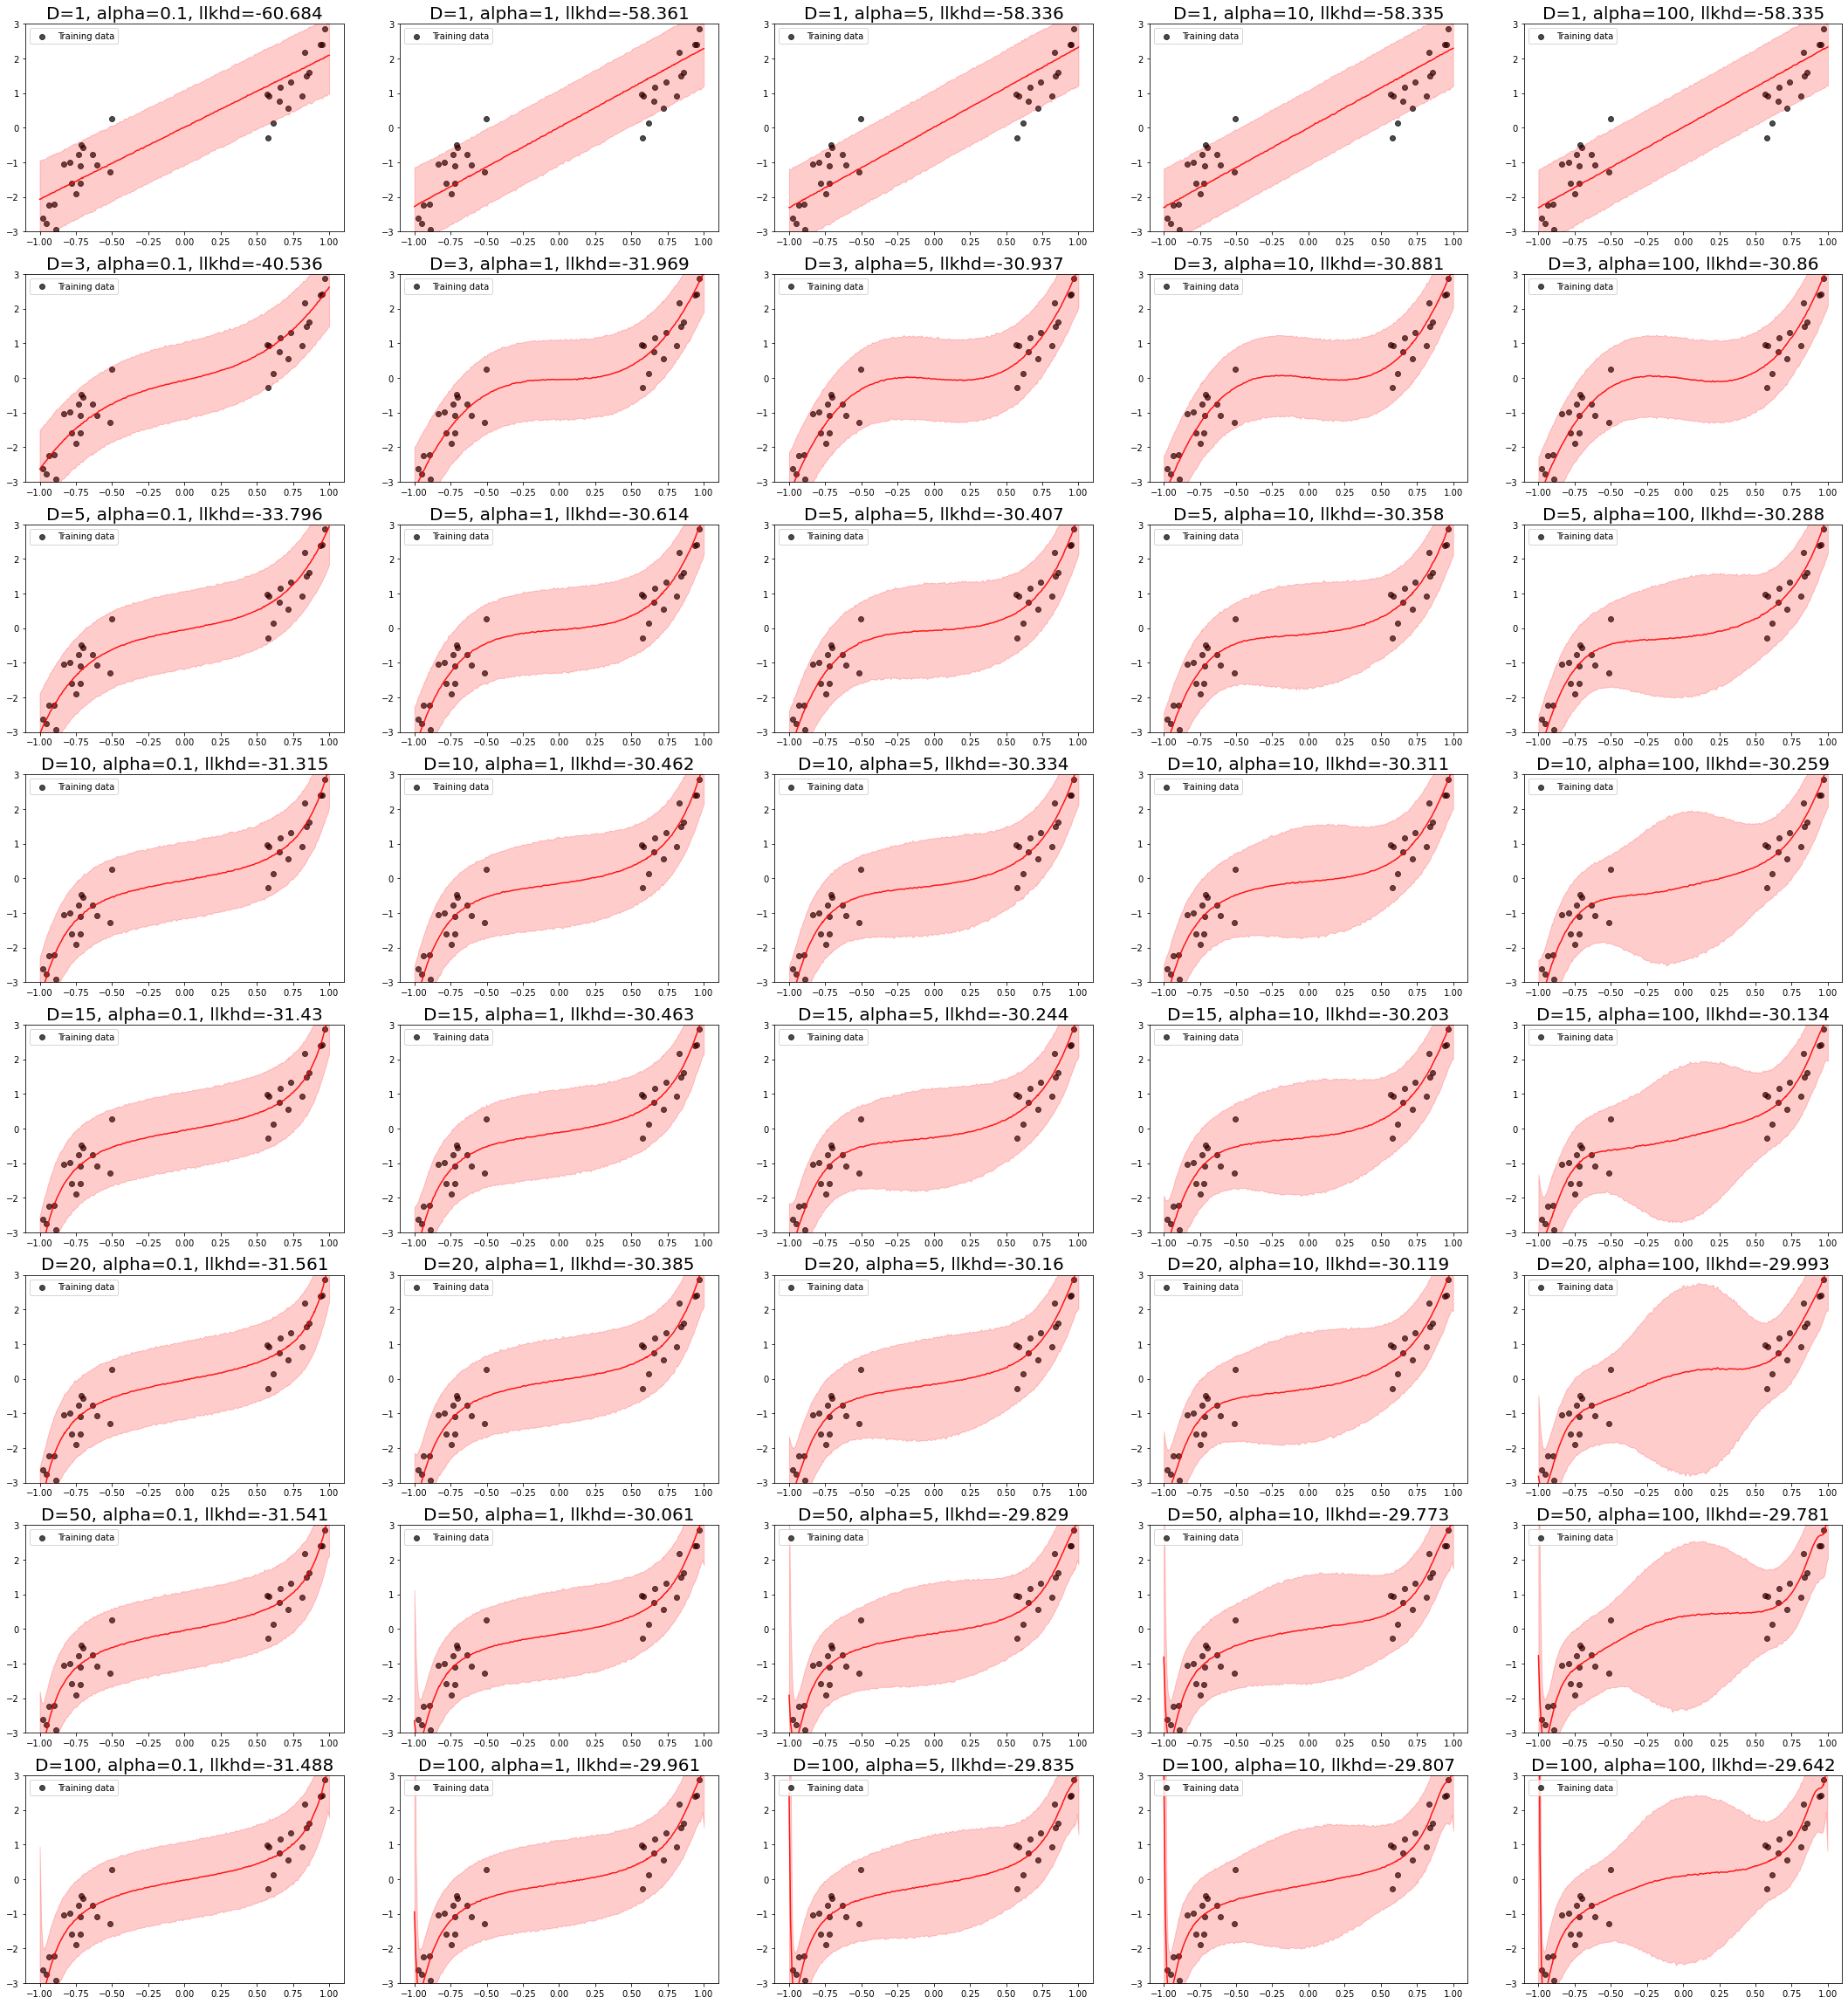

In [29]:
# Visualize the polynomial models
fig, ax = plt.subplots(8, 5, figsize=(30, 32))

for i in range(len(alphas)):
    
    y_preds = predictions[i]
    
    # Compute the 97.5 th percentile of the posterior predictive predictions
    pred_ub = np.percentile(y_preds, 97.5, axis=1)

    # Compute the 50 th percentile of the posterior predictive predictions
    pred_mean = np.percentile(y_preds, 50.0, axis=1)

    # Compute the 2.5 th percentile of the posterior predictive predictions
    pred_lb = np.percentile(y_preds, 2.5, axis=1)
    
    for j in range(len(degrees)):
        ax[j, i].scatter(x_train, y_train, color='black', alpha=0.7, label='Training data') #scatter plot the training data
    
        # Plot 95% predictive interval
        ax[j, i].fill_between(x_test, pred_ub[j], pred_lb[j], color='red', alpha=0.2)
        ax[j, i].plot(x_test, pred_mean[j], color='red', alpha=0.9)

        ax[j, i].legend(loc='upper left')
        ax[j, i].set_title('D={}, alpha={}, llkhd={}'.format(degrees[j], alphas[i], np.round(llkhds[i][j], 3)), fontsize= 20)
        ax[j, i].set_ylim((-3, 3))
        
plt.tight_layout()
plt.show()

There are two trends we can note:
1. The models with higher log-likelihood have posterior predictive distributions that fit the training data better.
2. There is no obvious relationship between desirable predictive uncertainty in the gap region and log-likelihood. For example, $D=100, \alpha=1$ has a similar (and high) log-likelihood as $D=20, \alpha=100$. But the first model has constant predictive uncertainty in the gap region, whereas the predictive uncertainty of the second model scales with distance to the training data. Similarly, look at $D=3, \alpha=100$ and $D=10, \alpha=100$.

From this, we can conclude that it does not seem like we can use the log-likelihood of the training data as an indicator of the quality of our predictive uncertainty away from the training data.

**(Model Selection via Cross-Validation)** For Bayesian kernel regression models we can also perform model selection for $D$ and $\alpha$ using a form of Occam's Razor: select the minimal complexity of model that has the highest avareage validation log-likelihood. <br><br>
We again select the optimal hyperparameters via cross-validation (by bootstrap):

  1. randomly sample two datasets from the observed data: one for training and one for validation. Fit a Bayesian kernel regression model with some choice of $D$ and $\alpha$ on the training data and evaluate its the log-likelihood of the validation data. Over $S$ number of such randomly sampled pairs of datasets, average the model's validation log-likelihood.
  2. plot the validation score as a function of model complexity, the polynomial degree $d$. 
  3. based on the plot, select the the minimal degree that achieves a high average validation performance (i.e. look for the 'elbow' of the plot).

  In the following, we implement model selection for Bayesian polynomial regression by cross-validation for a toy dataset with 400 observations (`number_of_points=200`) and select an optimal degree from $D=[1,3,5,10,15,20,50,100]$, fixing $\alpha=100$. 
  
  We then visualize the 95% posterior predictive interval for each model. We investigate whether we select the model with the most desirable predictive uncertainty.
  <br><br>
  **Note:** Model selection of Bayesian models by cross-validation is common practice but it is not perfectly principled. Later in the course we will look at an alternate but less tractable way of performing model selection: by computing the **model evidence**.
  
We first compute the average validation log-likelihood for $D=[1,3,5,10,15,20,50,100]$ using polynomial models.

In [30]:
S = 10
alpha = 100
predictions = []
degrees = [1, 3, 5, 10, 15, 20, 50, 100]
llkhds = []


llkhds = []
# Fit MLE polynomial models with different degrees to the dataset
for d in degrees:
    print('Number of polynomial features', d)
    
    val_llkhds = []
    for s in range(S):
         # Generate a random training samples from the true distribution over x
        x_train, y_train, _ = generate_data(number_of_points=200, noise_variance=0.3)
        # Generate a random validation samples from the true distribution over x
        x_valid, y_valid, _ = generate_data(number_of_points=200, noise_variance=0.3)
        
        # Make an instance of the PolynomialFeatures model to add polynomial powers to our covariates
        poly = PolynomialFeatures(d)
        # Fit our PolynomialFeatures to our data and add add polynomial powers to our covariates
        x_train_poly = poly.fit_transform(x_train.reshape((-1, 1)))
        x_test_poly = poly.fit_transform(x_test.reshape((-1, 1)))
        x_valid_poly = poly.fit_transform(x_valid.reshape((-1, 1)))
        
        # Compute validation log-likelihood
        val_llkhds.append(log_likelihood(alpha, noise_variance, x_train_poly, y_train, x_valid_poly, y_valid))

    # Get samples from the posterior predictive
    _, posterior_predictive_samples = get_posterior_samples(alpha, noise_variance, x_train_poly, y_train.reshape((-1, 1)), x_test_poly, samples)
    # Make predictions
    predictions.append(posterior_predictive_samples)
    # Compute the mean validation log-likelihood
    llkhds.append(np.mean(val_llkhds))

Number of polynomial features 1
Number of polynomial features 3
Number of polynomial features 5
Number of polynomial features 10
Number of polynomial features 15
Number of polynomial features 20
Number of polynomial features 50
Number of polynomial features 100


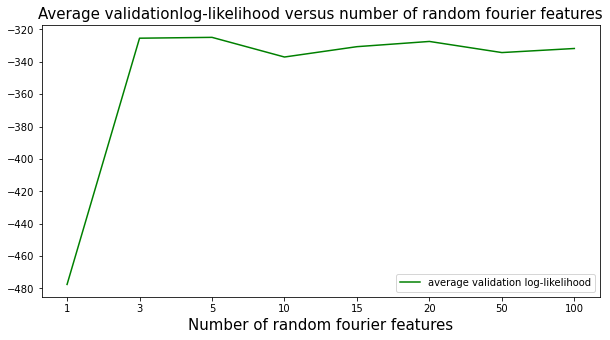

In [31]:
# Visualize the average validation mse for each degree
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(np.arange(len(degrees)), llkhds, color='green', label='average validation log-likelihood')
ax.set_xticks(np.arange(len(degrees)))
ax.set_xticklabels(degrees)
ax.set_title('Average validationlog-likelihood versus number of random fourier features', fontsize= 15)
ax.legend(loc='lower right')
ax.set_xlabel('Number of random fourier features',  fontsize=15)
plt.show()

It appears the the minimum $D$ that attains the highest average validation log-likelihood is $D=3$, that is, we've selected the degree 3 polynomial. 

Is this the model with the best uncertainty? Let's plot the 95% posterior predictive intervals of polynomial models with $D=[1,3,5,10,15,20,50,100]$.

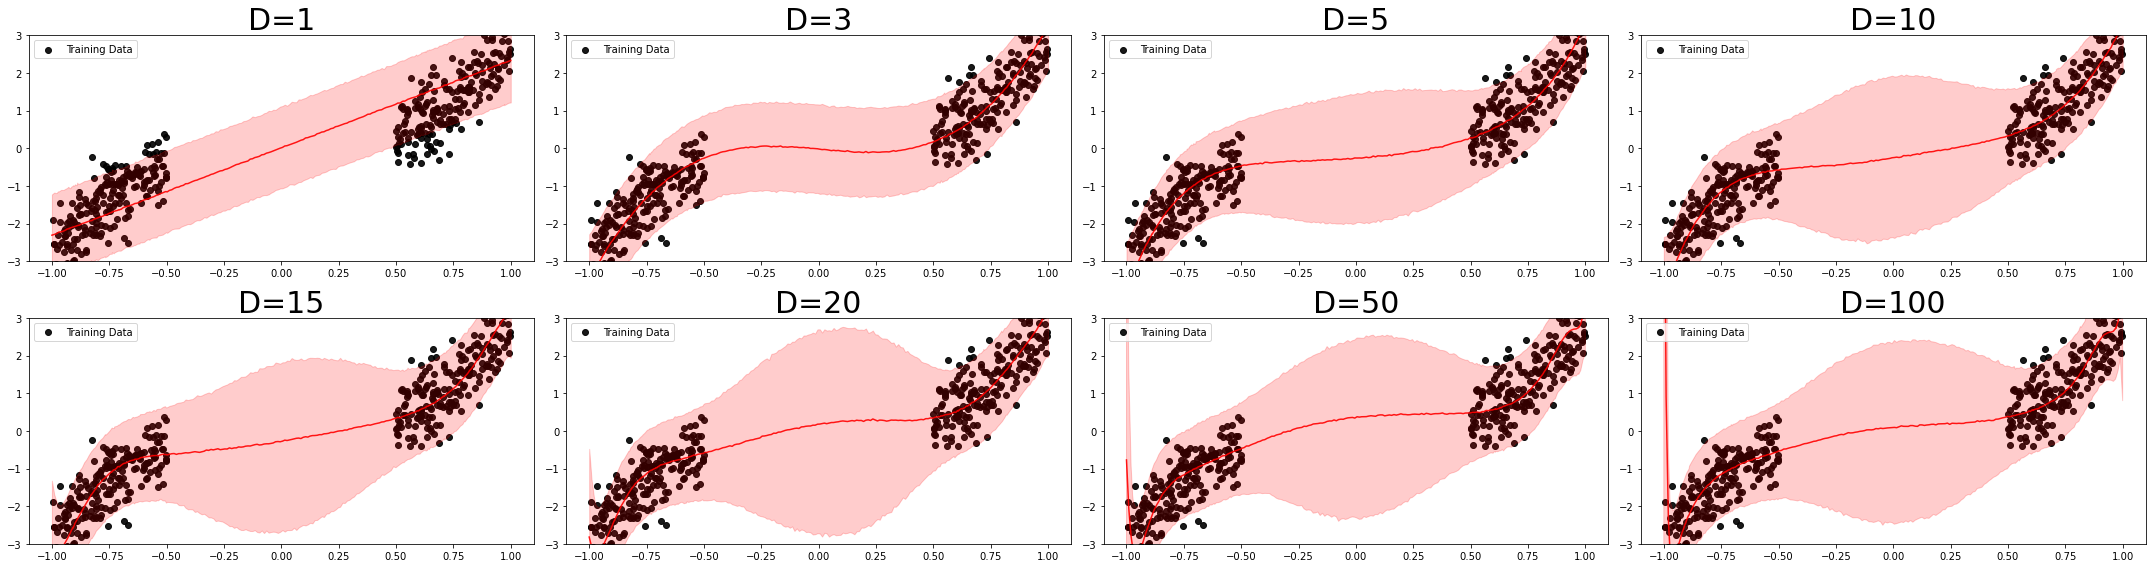

In [32]:
# Visualize the polynomial models
fig, ax = plt.subplots(2, 4, figsize=(30, 8))

for i in range(len(degrees)):
    ys = predictions[i].flatten()
    row = i // 4
    col = i % 4
    
    ax[row, col].scatter(x_train, y_train, color='black', alpha=0.9, label='Training Data') #scatter plot the training data
    
    # Plot 95% predictive interval
    ax[row, col].fill_between(x_test, pred_ub[i], pred_lb[i], color='red', alpha=0.2)
    ax[row, col].plot(x_test, pred_mean[i], color='red', alpha=0.9)
    
    ax[row, col].legend(loc='upper left')
    ax[row, col].set_title('D={}'.format(degrees[i]), fontsize= 30)
    ax[row, col].set_ylim((-3, 3))
    
plt.tight_layout()
plt.show()

Unfortunately, by applying Occam's Razor, we did not select the model with the most desirable predictive uncertainty! With a degree 3 polynomial model, the posterior predictive uncertainty in the gap region is constant. 

Again, this should not be surprise, since validation log-likelihood selects the model that fits best to data that is sampled from the regions where the training data is located - nothing about the log-likelihood encourages desirable properties of predictive uncertainty away from the training data!

## Part III: Comparisons and Conclusions

Starting in 2020, major machine learning conferences are beginning to ask authors as well as reviewers to explicitly consider the broader impact of new machine learning methods. To properly evaluate the potential good or harm that a piece of technology (AI or not) can do to the general public, we need to be aware that no technology is deployed in ideal conditions or in perfectly neutral contexts. In order to assess the potential broader impact of technology, we need to analyze the social systems/institutions of which these technologies will become a part.

To help you analyze the broader impact of your technology, begin by considering the following questions:

I. Identify the relevant socio-technical systems
  - In what social, political, economic system could the tech be deployed?
  - How would the tech be used in these systems (what role will it take in the decision making processes)?<br><br>
  
II. Identify the stakeholders
  - Who are the users?
  - Who are the affected communities (are these the users)?
  
    ***Hint:*** users are typically decision makers who will use the technology as decision aids (e.g. doctors), whereas affected communities may be folks who are impacted by these decisions but who are not represented in the decision making process (e.g. patients).<br><br>
    
III. What types of harm can this tech do?
  - What kinds of failures can this tech have?
  - What kinds of direct harm can these failures cause?
  - What kinds of harm can the socio-technical system cause?
  
    ***Hint:*** many technical innovations have niche applications, they may sit in a long chain of decision making in a complex system. As such, it may seem, at first glance, that these technologies have no immediate real-life impact. In these cases, it’s helpful to think about the impact of the entire system and then think about how the proposed innovations aid, hamper or change the goals or outcomes of this system.<br><br>
    
IV. What types of good can this tech do?
  - What kinds of needs do these users/communities have?
  - What kinds of constraints do these users/communities have?

1. **(Impact)**  Analyze the broader impact of these polynomial models. Focus on anticipating ways these models can interact with other components of the decision systems in which they will be deployed, identifying end-users, affected communities as well as anticipating the effects (positive and negative) on affected communities (in particular, does the model have the same effect on all subpopulations in the affected communities?). 

  Specifically address how predictive uncertainty can impact decision making when the models are deployed.
  
**Solutions:** In this context, where the model predicts diastolic blood pressure given patient age, the end-users and affected communities (as well as their relationship) are as in In-Class Exercise 09.02. The main difference is that we notice a significant age gap in the training data, i.e. for a certain age range, we have no observations of patient blood pressure. Thus, the performance of the model cannot be gauranteed for thoses patients (the model is essentially untested for the patients in the age gap). In this case, from our data visualization, we can estimate the range of the gap and can avoid over-relying on any model trained on this training set when predicting for a patient falling into this gap. However, in general, when the data is high dimensional it is an open research question how to gauge which subpopulation is overrepresented and which is underrepresented (it is also frequently the case that populations that are underrepresented in healthcare data are especially medically vunerable or historically marginalized). Thus, we need to be always concerned that a test input is potentially out of the distribution (OOD) of the model's training set. Unfortunately, most ML models do not alert the end-user when opertating far beyond it's comfort zone (i.e. out of distribution)! This is precisely where having predictive uncertainty can help alert the users to instances where the model is not confident in its predictions, e.g. when the test input is out of distribution of the model's training data.
  
  
2. **(Bayesian versus Frequentist Uncertainty)** Compare the types of predictive uncertainties that are generated by Bayesian models and ensembles. Characterize the advantages and disadvantages of bootstrap uncertainties from an ensemble. Describe an situation where it would be better to compute bootstrap uncertainties rather than posterior predictive uncertainties from a Bayesian model.

  ***Hint:*** For example, consider situations where the data is scarce versus situations where the data is abundant; consider situations where clinicians can provide guidance on model selection using domain expertise versus situations where we would not know how patterns in the data would extrapolate to new populations of patients.

  Characterize the advantages and disadvantages of posterior predictive uncertainties from a Bayesian model. Describe an application where it is better to use these uncertainties rather than bootstrap uncertainties from an ensemble.

**Solution:** 

Unregularized bootstrap uncertainties can be overly large in training-data rich regions when the number of observations is small. When the number of observations is large, the predictive uncertainty in training-data rich region are overly small. Both types of mis-calibration in the predictive uncertainties are undesirable. In training-data poor regions, these uncertainties can be exaggerated/extreme and uninformative (they do not give a sensible scale for the uncertainty) - this uncertainty may not be significantly reduced with more observations. Furthermore, unfortunately, regularization tend to completely collapse predictive uncertainties!

Nonetheless, bootstrap uncertainties are easy to compute (training an ensemble of even very large models in parallel may not be that expensive these days), whereas Bayesian predictive uncertainties are only available if we know how to sample from the posterior (for many models the posteriors are intractably complicated and must be approximated).

Posterior predictive uncertainties of Bayesian kernel regression models are sensitive to the choice of prior and the feature map. While the predicitve uncertainties of Bayesian models are regularized even for small number of observations, for the wrong choices of feature map and/or prior, the predictive uncertainties in training data poor regions can be uninformative (the model is just as uncertain in data-rich regions as it is in data poor regions). 

If we are able to sample from the posterior of Bayesian regression models and if we have a prior/feature map that we believe is appropriate for the data/task, we may prefer to use the posterior predictive uncertainties from Bayesian models since they are better regularized (and we understand how to tune our model by adjusting our choice of prior and feature map). 

3. **(Measuring Uncertainty)** From your experiments, are any of the model evaluation metrics consdiered in this assignment (MSE, log-likelihood) appropriate for evaluating the quality of predictive uncertainty far away from the training data, that is, if we are concerned about the performance of models under covariate shift should we use these metrics to perform model selection? 

  Do our commonly used "best practices" of training machine learning models help or hamper our ability to train models with useful predictive uncertainties?

  What would be a good metric for measuring uncertainty? How would you define "good" uncertainty in the first place?

  ***Hint:*** Can you formulate a definition of "good" uncertainty without referencing a specific down-stream task?

**Solution:**

From our empirical experiments we see that validation MSE and log-likelihood does not measure the quality of predictive uncertainty in regions far from the training data (i.e. out of distribution regions). This isn't terribly surprising since these metrics measure how well our model captures the trend for datasets that are distributed like our training data - nothing in these metrics explictly encourages properties predictive uncertainties to align with our task specific goals. 

This means that if we want our models to behave in specific ways outside of the training data distribution, we need to explore new metrics/tools for model training and selection.

It's tough to define "good" uncertainty absent a task. For example, if we just wanted to use the uncertainty to alert us that a test inupt is out of distribution (OOD), then we'd just want the predictive uncertainty to be much larger in gap regions and smaller in regions where we have a lot of training data. But if we wanted a "scale" for our uncertainty, we might want uncertainty that grows as we move farther away from the training data. Furthermore, if I didn't use my model for prediction but for interpretation, then I might not care if the predictive uncertainty captures the amount of noise in the data; on the other hand, if I intend to use the model for predictions, then I very much care about having predictive uncertainty that matches the noise level in the data. 